In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]
from scipy.ndimage import gaussian_filter

In [2]:
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [3]:
# Initialize LineModel with default model
m = lim()
m_cii = lim('Lichen_v3', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [3]:
m_cii.update(model_par = {'zdex': 0.0,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.017,
 'BehrooziFile': 'sfr_reinterp.dat'})

In [4]:
m_cii.model_par

{'zdex': 0.0,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.017,
 'BehrooziFile': 'sfr_reinterp.dat'}

## Stellar Mass / Halo mass / SFR relationships

Dongwoo's code for Behroozi+2013 implementation of Stellar mass:

In [4]:
a = lambda z:1/(1.+z)
# Behroozi et al 2013a parameters
nu = lambda z:np.exp(-4*a(z)**2)
log10_eps = lambda z:-1.777-0.006*(a(z)-1)*nu(z)-0.119*(a(z)-1)
log10_M1 = lambda z:11.514+(-1.793*(a(z)-1)-0.251*z)*nu(z)
alpha = lambda z:-1.412+0.731*(a(z)-1)*nu(z)
delta = lambda z:3.508+(2.608*(a(z)-1)-0.043*z)*nu(z)
gamma = lambda z:0.316+(1.319*(a(z)-1)+0.279*z)*nu(z)
f = lambda x,z:-np.log10(10**(alpha(z)*x)+1)+delta(z)*(np.log10(1+np.exp(x)))**gamma(z)/(1+np.exp(10**(-x)))
xi = lambda z:0.218-0.023*(a(z)-1)

def stellar_m(halo_m,z,scatter=True):
    sm = 10**(log10_eps(z)+log10_M1(z)+f(np.log10(halo_m/(10**log10_M1(z))),z)-f
(0,z))
    if scatter:
        rand = np.random.lognormal(-0.5*(xi(z)*np.log(10))**2,xi(z)*np.log(10))
        return sm*rand
    else:
        return sm

In [9]:
halo_ms = m_cii.halos.M

Loading .npz catalogues...


In [10]:
halo_zs = m_cii.halos.redshift

In [11]:
map_zs = (m_cii.mapinst.nu_rest/m_cii.mapinst.nu_bincents) - 1
med_z = np.median(map_zs)

In [12]:
halo_sm = stellar_m(halo_ms, med_z)

Loading SFR:

In [13]:
from limlam_mocker import limlam_mocker as llm
import scipy as sp
import scipy.interpolate
sigma_sfr = 0.3

In [14]:
tablepath = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/sfr_reinterp.dat'

In [15]:
dat_zp1, dat_logm, dat_logsfr, _ = np.loadtxt(tablepath, unpack=True)
dat_logzp1 = np.log10(dat_zp1)
dat_sfr    = 10.**dat_logsfr
dat_logzp1  = np.unique(dat_logzp1)    # log(z), 1D 
dat_logm    = np.unique(dat_logm)      # log(Mhalo), 1D        
dat_sfr     = np.reshape(dat_sfr, (dat_logm.size, dat_logzp1.size))
sfr_interp_tab = sp.interpolate.RectBivariateSpline(dat_logm, dat_logzp1, dat_sfr, kx=1, ky=1)

In [16]:
halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs + 1))

Text(0, 0.5, 'SFR')

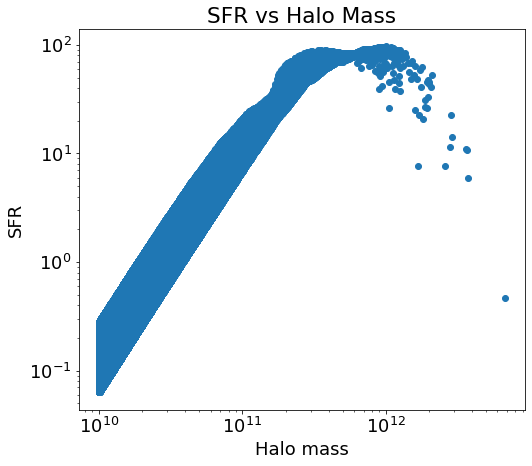

In [17]:
plt.scatter(halo_ms, halo_sfr)
plt.xscale('log')
plt.yscale('log')
plt.title('SFR vs Halo Mass')
plt.xlabel('Halo mass')
plt.ylabel('SFR')

Metallicity implementation:

In [18]:
gamma = 0.31
beta = 2.1
m_0 = 10.11
m_1 = 0.56
Z_0 = 8.779

In [19]:
def M_0(sfr):
    return (10**(m_0))*(sfr**(m_1))

In [20]:
halo_M0 = M_0(halo_sfr)

In [21]:
def metal(stellar_m, M_0):
    return Z_0 - (gamma/beta)*np.log10(1 + (stellar_m/M_0)**(-beta))

In [22]:
halo_z = metal(halo_sm, halo_M0)

Text(0, 0.5, 'Halo Metallicity')

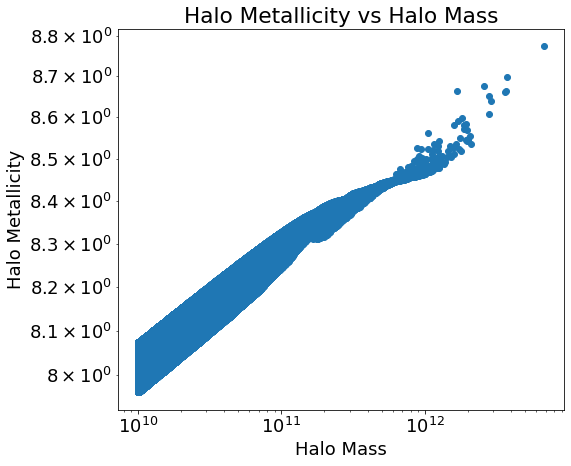

In [23]:
plt.scatter(halo_ms, halo_z)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo Metallicity vs Halo Mass')
plt.xlabel('Halo Mass')
plt.ylabel('Halo Metallicity')

In [21]:
sfr_0 = 1
logsfr_0 = np.log10(sfr_0)

In [22]:
m_range = np.logspace(8, 12, 1000)

In [23]:
M_0_0 = M_0(sfr_0)

In [24]:
z_0 = metal(m_range, M_0_0)

Text(0, 0.5, 'Halo Metallicity')

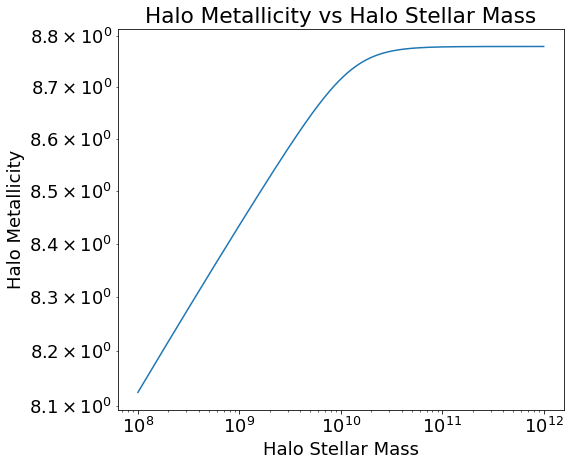

In [82]:
plt.plot(m_range, z_0)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo Metallicity vs Halo Stellar Mass')
plt.xlabel('Halo Stellar Mass')
plt.ylabel('Halo Metallicity')

In [83]:
sm_0 = 10**9
logsm_0 = np.log10(sm_0)

In [84]:
sfr_range = np.logspace(-2, 2, 1000)

In [85]:
M_0_1 = M_0(sfr_range)

In [86]:
z_1 = metal(sm_0, M_0_1)

Text(0, 0.5, 'Halo Metallicity')

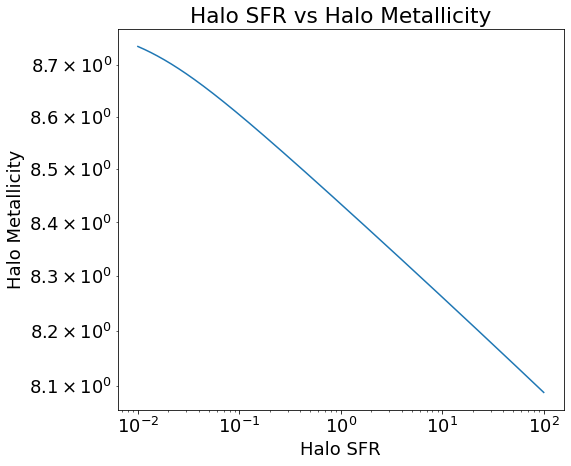

In [87]:
plt.plot(sfr_range, z_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo SFR vs Halo Metallicity')
plt.xlabel('Halo SFR')
plt.ylabel('Halo Metallicity')

## Halo Cut Off

In [21]:
from limlam_mocker import limlam_mocker as llm
import scipy as sp
import scipy.interpolate
sigma_sfr = 0.3

In [ ]:
/home/horlaville/clara_limlam/limCode2020-master_clara_2

In [12]:
tablepath = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/sfr_behroozi_release.dat'

In [23]:
dat_zp1, dat_logm, dat_logsfr, _ = np.loadtxt(tablepath, unpack=True)
dat_logzp1 = np.log10(dat_zp1)
dat_sfr    = 10.**dat_logsfr
dat_logzp1  = np.unique(dat_logzp1)    # log(z), 1D 
dat_logm    = np.unique(dat_logm)      # log(Mhalo), 1D        
dat_sfr     = np.reshape(dat_sfr, (dat_logm.size, dat_logzp1.size))
dat_logsfr  = np.reshape(dat_logsfr, dat_sfr.shape)

In [24]:
from scipy.interpolate import SmoothBivariateSpline
dat_logzp1_,dat_logm_ = np.meshgrid(dat_logzp1,dat_logm)
badspl = SmoothBivariateSpline(dat_logzp1_[-1000<(dat_logsfr)],dat_logm_[-1000<(dat_logsfr)],dat_logsfr[-1000<(dat_logsfr)],kx=4,ky=4)
dat_sfr[dat_logsfr==-1000.] = 10**badspl(dat_logzp1,dat_logm).T[dat_logsfr==-1000.]
        
# Get interpolated SFR value(s)    
sfr_interp_tab = sp.interpolate.RectBivariateSpline(dat_logm, dat_logzp1, dat_sfr, kx=1, ky=1)

In [25]:
halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs + 1))

Text(0, 0.5, 'SFR')

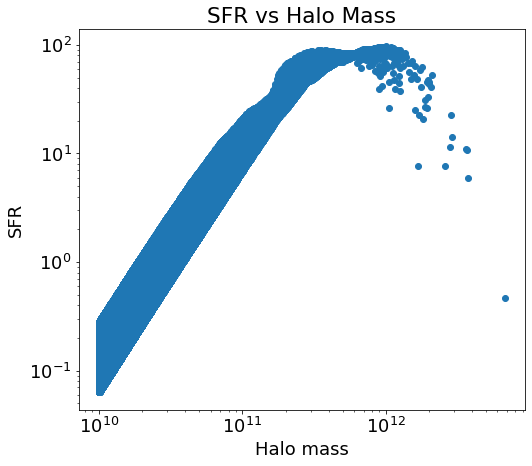

In [26]:
plt.scatter(halo_ms, halo_sfr)
plt.xscale('log')
plt.yscale('log')
plt.title('SFR vs Halo Mass')
plt.xlabel('Halo mass')
plt.ylabel('SFR')

Text(0, 0.5, 'SFR')

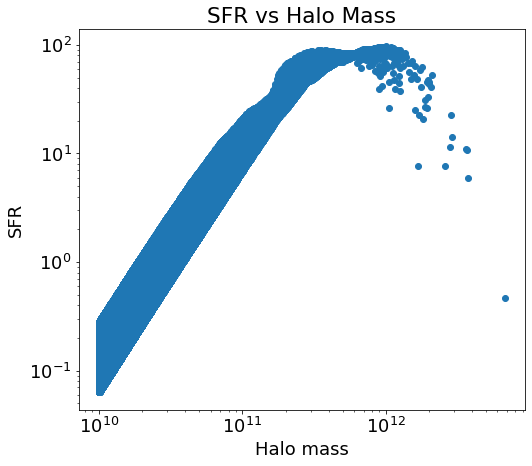

In [31]:
plt.scatter(halo_ms, halo_sfr)
plt.xscale('log')
plt.yscale('log')
plt.title('SFR vs Halo Mass')
plt.xlabel('Halo mass')
plt.ylabel('SFR')

In [27]:
halo_M0 = M_0(halo_sfr)

In [28]:
halo_z = metal(halo_sm, halo_M0)

Text(0, 0.5, 'Halo Metallicity')

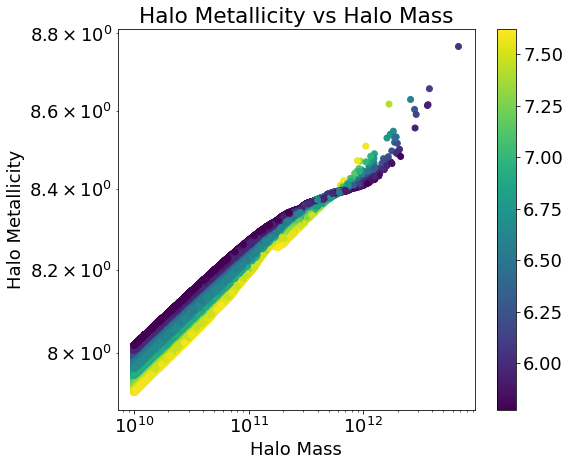

In [29]:
plt.scatter(halo_ms, halo_z, c = halo_zs)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.title('Halo Metallicity vs Halo Mass')
plt.xlabel('Halo Mass')
plt.ylabel('Halo Metallicity')

Text(0, 0.5, 'Halo Metallicity')

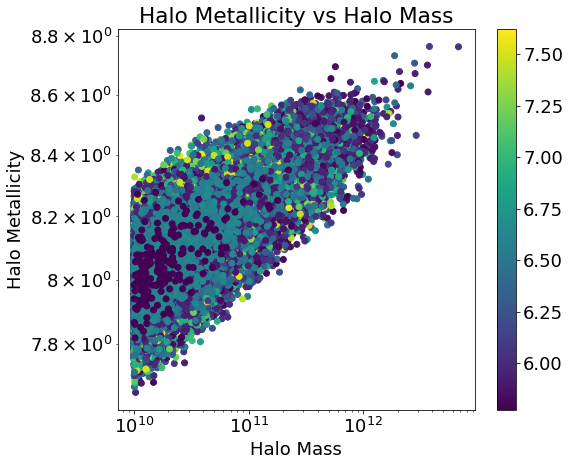

In [32]:
plt.scatter(halo_ms, halo_z, c = halo_zs)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.title('Halo Metallicity vs Halo Mass')
plt.xlabel('Halo Mass')
plt.ylabel('Halo Metallicity')

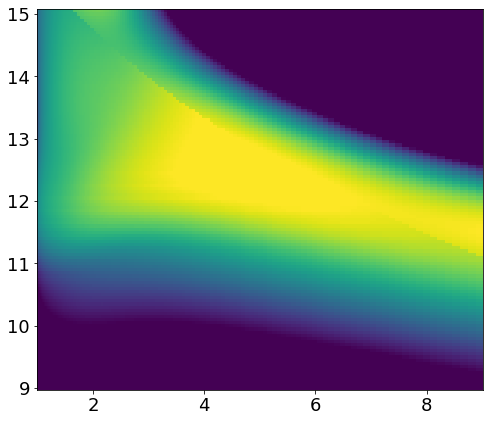

In [111]:
# DTC driving for a bit ...
plt.pcolormesh(10**dat_logzp1,dat_logm,np.log10(dat_sfr),vmin=-2,vmax=2)

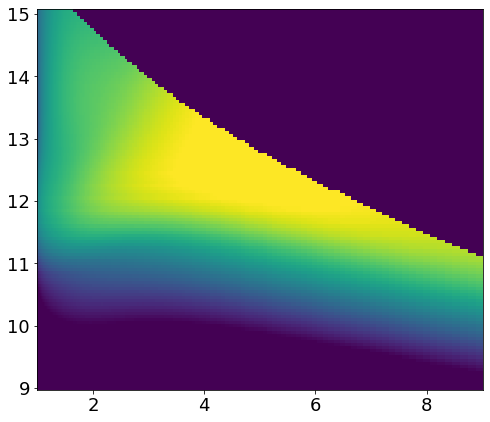

In [112]:
plt.pcolormesh(10**dat_logzp1,dat_logm,dat_logsfr,vmin=-2,vmax=2)

In [117]:
_,_,_,dat_log_sm_med = np.loadtxt(tablepath, unpack=True)

In [118]:
dat_log_sm_med

array([ 5.841552,  5.842527,  5.843247, ..., 10.726083, 10.712571,
       10.698079])

In [123]:
tuple(zip(10**dat_logzp1_.flatten(),dat_logm_.flatten(),np.log10(dat_sfr).flatten(),dat_log_sm_med))[:10]

((1.0, 9.0, -4.109195, 5.841552),
 (1.016249, 9.0, -4.041178, 5.842527),
 (1.032761, 9.0, -3.969078, 5.843247),
 (1.049542, 9.0, -3.910695, 5.843692),
 (1.066596, 9.0, -3.862484, 5.843835),
 (1.083927, 9.0, -3.823168, 5.843649),
 (1.101539, 9.0, -3.789299, 5.843096),
 (1.119438, 9.0, -3.759242, 5.842162),
 (1.137627, 9.0, -3.732249, 5.840821),
 (1.156112, 9.0, -3.708302, 5.839025))

In [121]:
# let's rewrite the table file somewhere else ...

In [122]:
%pwd

'/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2'

In [125]:
with open('sfr_reinterp.dat','w') as f:
    f.write('#(1+z) Log10(Halo Mass) Log10(<SFR>) Log10(Median SM)\r\n')
    f.write('#Units are Msun, Msun/yr, and Msun, respectively.\r\n')
    f.write('#(includes crude extrapolation into unphysical halo mass ranges)\r\n')
    for dat_tuple in zip(10**dat_logzp1_.flatten(),dat_logm_.flatten(),np.log10(dat_sfr).flatten(),dat_log_sm_med):
        f.write('{:.6f} {:.6f} {:.6f} {:.6f}\r\n'.format(*dat_tuple))

In [131]:
m_cii.z

<Quantity 6.588>

In [132]:
np.mean(map_zs)

6.624655345621224

## Metallicity Cube

In [134]:
def metal(ps_m):
    return 10**(ps_m - 8.69)

In [135]:
real_Z = metal(halo_z)

In [137]:
bins3D = [m_cii.mapinst.pix_binedges_x, m_cii.mapinst.pix_binedges_y, m_cii.mapinst.nu_binedges[::-1]]

In [138]:
n_halos, _ = np.histogramdd( np.c_[m_cii.halos.ra, m_cii.halos.dec, m_cii.halos.nu], 
                                  bins    = bins3D)

In [140]:
tot_met, _ = np.histogramdd( np.c_[m_cii.halos.ra, m_cii.halos.dec, m_cii.halos.nu], 
                                  bins    = bins3D, weights = real_Z)

In [141]:
avg_met = tot_met/n_halos
avg_met = avg_met[:,:,::-1]

/tmp/ipykernel_2926842/499547231.py:1: RuntimeWarning: invalid value encountered in divide
  avg_met = tot_met/n_halos


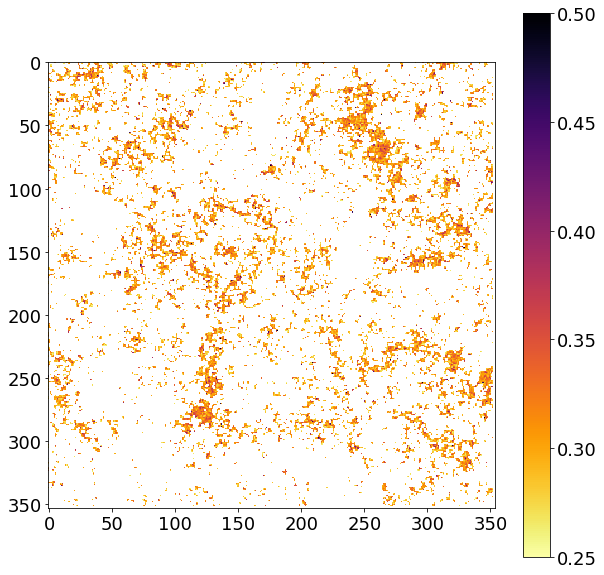

In [163]:
plt.figure(figsize=(10,10))
plt.imshow(avg_met[:, :, 3], cmap=plt.cm.inferno_r, vmin=0.25, vmax=0.5)
plt.colorbar()

## SFR / CII Relationship

In [25]:
halos_cii = m_cii.L_halos

/cita/modules/python/3.10.2/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


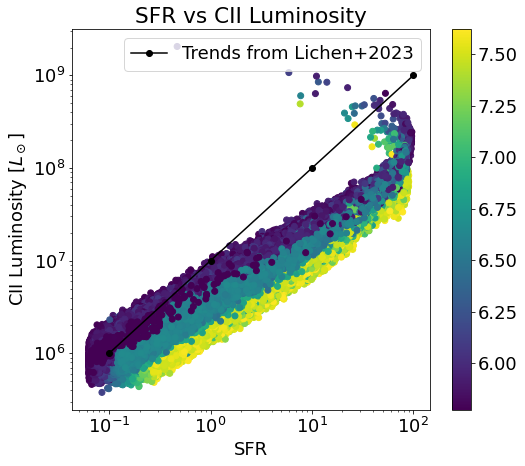

In [26]:
plt.scatter(halo_sfr, halos_cii, c = halo_zs)
plt.colorbar()
plt.title('SFR vs CII Luminosity')
plt.xlabel('SFR')
plt.ylabel(r'CII Luminosity [$L_\odot$]')
plt.xscale('log')
plt.yscale('log')
plt.plot([10**(-1), 10**(0), 10**(1), 10**(2)], [10**(6), 10**(7), 10**(8), 10**(9)], '-ok', label = 'Trends from Lichen+2023')
plt.legend()

/cita/modules/python/3.10.2/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


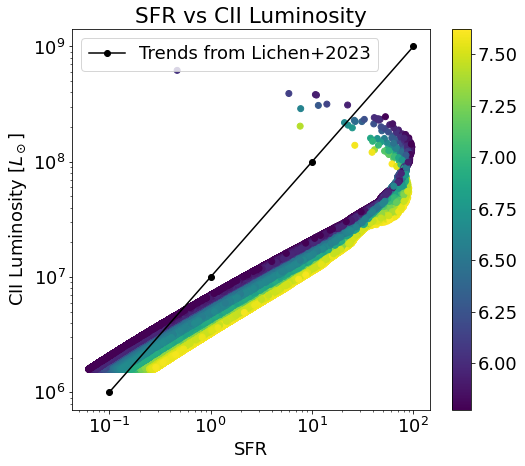

In [176]:
plt.scatter(halo_sfr, halos_cii, c = halo_zs)
plt.colorbar()
plt.title('SFR vs CII Luminosity')
plt.xlabel('SFR')
plt.ylabel(r'CII Luminosity [$L_\odot$]')
plt.xscale('log')
plt.yscale('log')
plt.plot([10**(-1), 10**(0), 10**(1), 10**(2)], [10**(6), 10**(7), 10**(8), 10**(9)], '-ok', label = 'Trends from Lichen+2023')
plt.legend()

/cita/modules/python/3.10.2/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


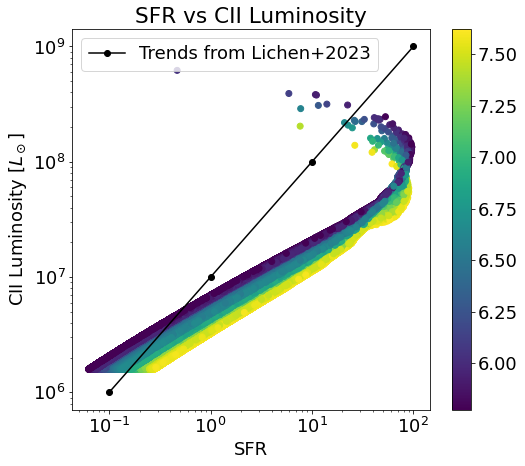

In [19]:
plt.scatter(halo_sfr, halos_cii, c = halo_zs)
plt.colorbar()
plt.title('SFR vs CII Luminosity')
plt.xlabel('SFR')
plt.ylabel(r'CII Luminosity [$L_\odot$]')
plt.xscale('log')
plt.yscale('log')
plt.plot([10**(-1), 10**(0), 10**(1), 10**(2)], [10**(6), 10**(7), 10**(8), 10**(9)], '-ok', label = 'Trends from Lichen+2023')
plt.legend()

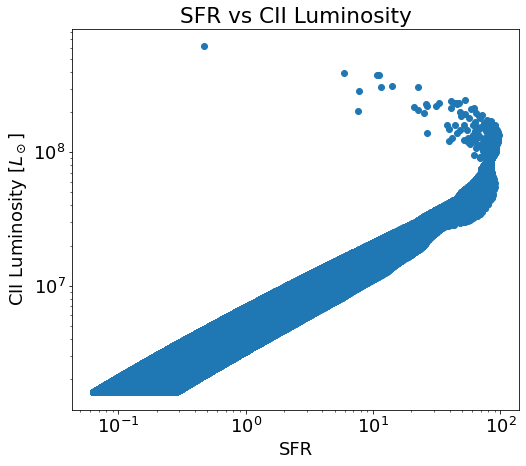

In [189]:
plt.scatter(halo_sfr, halos_cii)
plt.title('SFR vs CII Luminosity')
plt.xlabel('SFR')
plt.ylabel(r'CII Luminosity [$L_\odot$]')
plt.xscale('log')
plt.yscale('log')

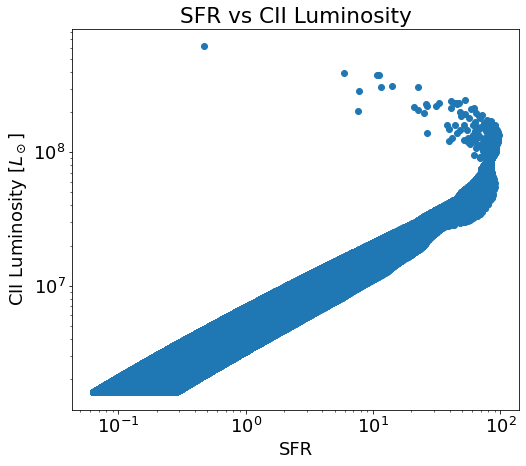

In [20]:
plt.scatter(halo_sfr, halos_cii)
plt.title('SFR vs CII Luminosity')
plt.xlabel('SFR')
plt.ylabel(r'CII Luminosity [$L_\odot$]')
plt.xscale('log')
plt.yscale('log')

In [27]:
halo_IR = halo_sfr*(1.36*(10**10))

Text(0, 0.5, '$L_{CII}/L_{IR}$')

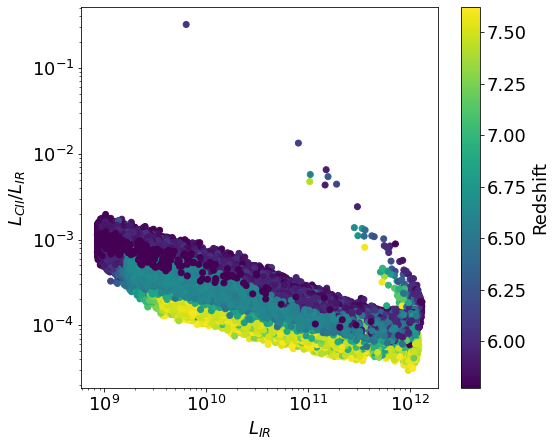

In [28]:
plt.scatter(halo_IR, (halos_cii/halo_IR), c = halo_zs)
plt.colorbar(label = 'Redshift')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}$')
plt.ylabel(r'$L_{CII}/L_{IR}$')

Text(0, 0.5, '$L_{CII}/L_{IR}$')

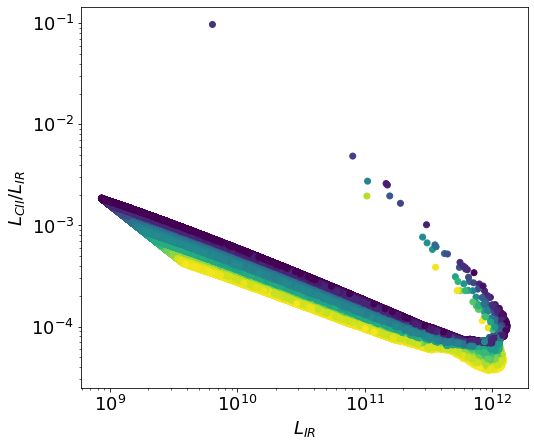

In [184]:
plt.scatter(halo_IR, (halos_cii/halo_IR), c = halo_zs)
plt.colorbar(label = 'Redshift')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}$')
plt.ylabel(r'$L_{CII}/L_{IR}$')

Text(0, 0.5, '$L_{CII}/L_{IR}$')

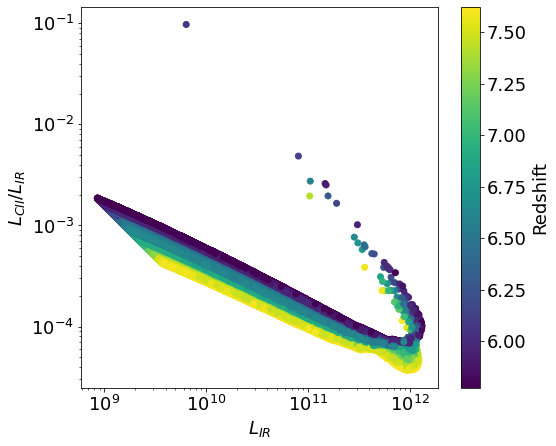

In [22]:
plt.scatter(halo_IR, (halos_cii/halo_IR), c = halo_zs)
plt.colorbar(label = 'Redshift')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}$')
plt.ylabel(r'$L_{CII}/L_{IR}$')

Text(0, 0.5, '$L_{CII}/L_{IR}$')

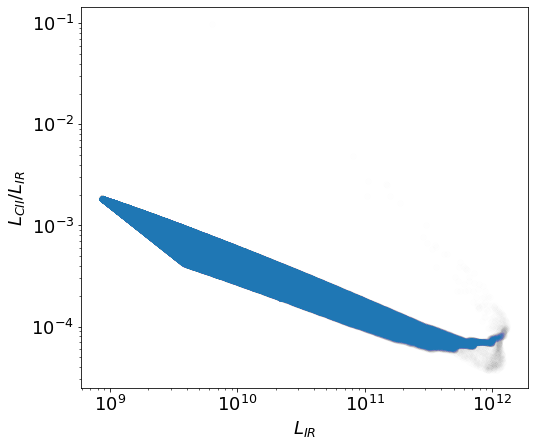

In [23]:
plt.scatter(halo_IR, (halos_cii/halo_IR), alpha = 0.004)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}$')
plt.ylabel(r'$L_{CII}/L_{IR}$')

In [12]:
halo_log10_Lcii = np.log10(halos_cii.value)
halo_log10_LIR = np.log10(halo_IR)

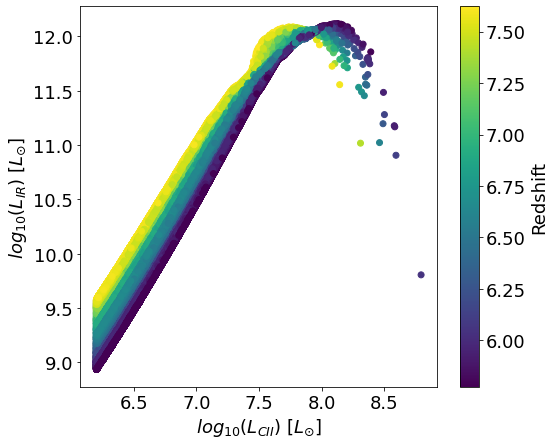

In [39]:
plt.scatter(halo_log10_Lcii, halo_log10_LIR, c = halo_zs)
plt.xlabel(r'$log_{10}(L_{CII})\ [L_{\odot}]$')
plt.ylabel(r'$log_{10}(L_{IR})\ [L_{\odot}]$')
plt.colorbar(label = 'Redshift')

## FIRE Galaxies

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]
from scipy.ndimage import gaussian_filter

In [2]:
# Initialize LineModel with default model
m = lim()
m_cii = lim('Lichen', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [3]:
cii_map = m_cii.maps

Loading .npz catalogues...


In [4]:
halo_ms = m_cii.halos.M
halo_zs = m_cii.halos.redshift

In [5]:
from limlam_mocker import limlam_mocker as llm
import scipy as sp
import scipy.interpolate
sigma_sfr = 0.3

In [6]:
tablepath = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/sfr_reinterp.dat'

In [7]:
dat_zp1, dat_logm, dat_logsfr, _ = np.loadtxt(tablepath, unpack=True)
dat_logzp1 = np.log10(dat_zp1)
dat_sfr    = 10.**dat_logsfr
dat_logzp1  = np.unique(dat_logzp1)    # log(z), 1D 
dat_logm    = np.unique(dat_logm)      # log(Mhalo), 1D        
dat_sfr     = np.reshape(dat_sfr, (dat_logm.size, dat_logzp1.size))
sfr_interp_tab = sp.interpolate.RectBivariateSpline(dat_logm, dat_logzp1, dat_sfr, kx=1, ky=1)

In [8]:
halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs + 1))

In [9]:
halos_cii = m_cii.L_halos

In [10]:
halo_IR = halo_sfr*(1.36*(10**10))

In [11]:
halo_log10_Lcii = np.log10(halos_cii.value)
halo_log10_LIR = np.log10(halo_IR)

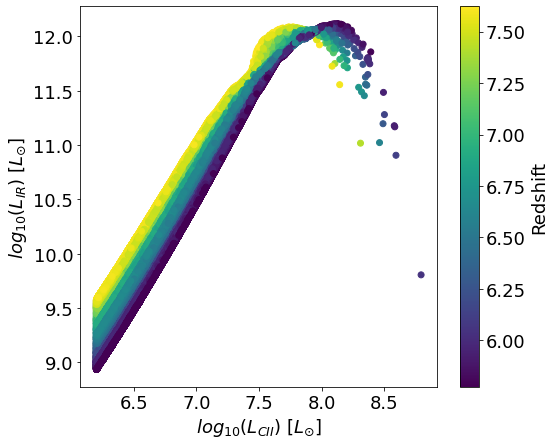

In [12]:
plt.scatter(halo_log10_Lcii, halo_log10_LIR, c = halo_zs)
plt.xlabel(r'$log_{10}(L_{CII})\ [L_{\odot}]$')
plt.ylabel(r'$log_{10}(L_{IR})\ [L_{\odot}]$')
plt.colorbar(label = 'Redshift')

In [31]:
fire_galaxies = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies.dat'

In [32]:
fire_galaxies = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies.dat'
massive, log_cii, log_ir = np.loadtxt(fire_galaxies, unpack=True)

In [33]:
fire_galaxies = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies.dat'
massive, log_cii, log_ir = np.loadtxt(fire_galaxies, unpack=True)

mass_fire = massive < 0
fire_box = massive >= 0
fire_zs = [6 for i in range(len(massive))]

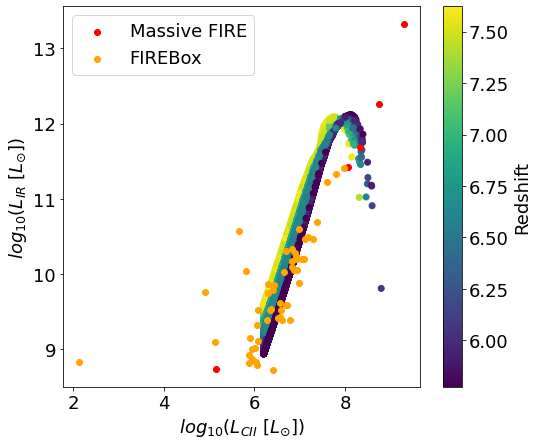

In [32]:
plt.scatter(halo_log10_Lcii, halo_log10_LIR, c = halo_zs)
plt.colorbar(label = 'Redshift')
plt.scatter(log_cii[mass_fire], log_ir[mass_fire], c = 'r', label = 'Massive FIRE')
plt.scatter(log_cii[fire_box], log_ir[fire_box], c = 'orange', label = 'FIREBox')
plt.xlabel(r'$log_{10}(L_{CII}\ [L_{\odot}])$')
plt.ylabel(r'$log_{10}(L_{IR}\ [L_{\odot}])$')
plt.legend()
plt.savefig('fire_galaxies.png', bbox_inches = "tight")

In [34]:
fire_galaxies = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies.dat'
massive, log_cii, log_ir = np.loadtxt(fire_galaxies, unpack=True)

mass_fire = massive < 0
fire_box = massive >= 0
fire_zs = [6 for i in range(len(massive))]

fire_cii = 10**(log_cii)
fire_ir = 10**(log_ir)

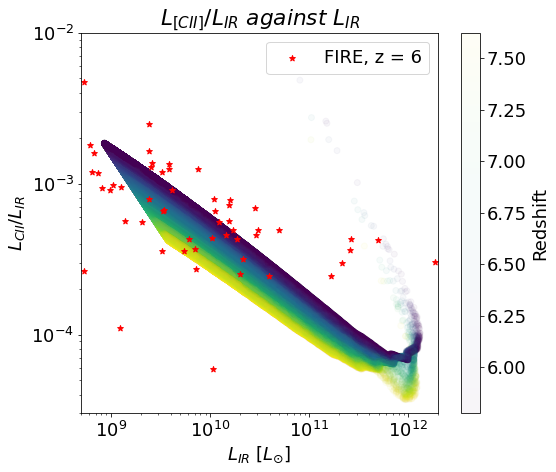

In [66]:
plt.scatter(halo_IR, (halos_cii/halo_IR), c = halo_zs, alpha = 0.04)
plt.colorbar(mappable = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax), label = 'Redshift')
plt.title(r'$L_{[CII]}/L_{IR}\ against\ L_{IR}$')
plt.scatter(fire_ir, (fire_cii/fire_ir), c = 'r', marker = '*', label = 'FIRE, z = 6')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ [L_{\odot}]$')
plt.ylabel(r'$L_{CII}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()
#plt.savefig('fire_cii_ir.png', bbox_inches = "tight")

In [42]:
import random
0.001*len(halo_IR) #1862
rand_halos = random.sample([i for i in range(len(halo_IR))], 1862)
rand_halos = np.array(rand_halos)

In [43]:
0.001*len(halo_IR)

1861.929

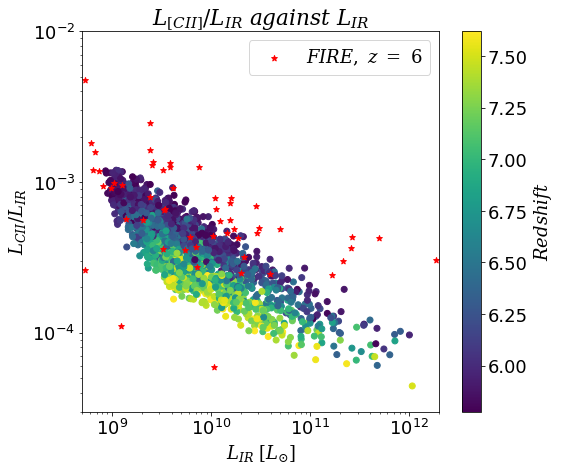

In [46]:
plt.rcParams["mathtext.fontset"] = "dejavuserif"

plt.scatter(halo_IR[rand_halos], (halos_cii/halo_IR)[rand_halos], c = halo_zs[rand_halos])
plt.colorbar(label = r'$Redshift$')
plt.title(r'$L_{[CII]}/L_{IR}\ against\ L_{IR}$')
plt.scatter(fire_ir, (fire_cii/fire_ir), c = 'r', marker = '*', label = r'$FIRE,\ z\ =\ 6$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ [L_{\odot}]$')
plt.ylabel(r'$L_{CII}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()

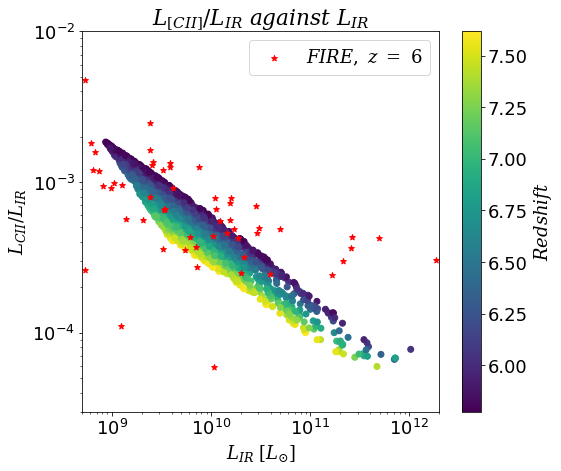

In [107]:
plt.rcParams["mathtext.fontset"] = "dejavuserif"

plt.scatter(halo_IR[rand_halos], (halos_cii/halo_IR)[rand_halos], c = halo_zs[rand_halos])
plt.colorbar(label = r'$Redshift$')
plt.title(r'$L_{[CII]}/L_{IR}\ against\ L_{IR}$')
plt.scatter(fire_ir, (fire_cii/fire_ir), c = 'r', marker = '*', label = r'$FIRE,\ z\ =\ 6$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ [L_{\odot}]$')
plt.ylabel(r'$L_{CII}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()

#plt.savefig('fire_cii_ir.pdf', bbox_inches = "tight")

Need to investigate the sources of scatter for the different models

Quick pipeline:

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]
from scipy.ndimage import gaussian_filter

lim model:

In [48]:
# Initialize LineModel with default model
m = lim()
m_cii_v1 = lim('Lichen', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


Functions:

In [49]:
a = lambda z:1/(1.+z)
# Behroozi et al 2013a parameters
nu = lambda z:np.exp(-4*a(z)**2)
log10_eps = lambda z:-1.777-0.006*(a(z)-1)*nu(z)-0.119*(a(z)-1)
log10_M1 = lambda z:11.514+(-1.793*(a(z)-1)-0.251*z)*nu(z)
alpha = lambda z:-1.412+0.731*(a(z)-1)*nu(z)
delta = lambda z:3.508+(2.608*(a(z)-1)-0.043*z)*nu(z)
gamma = lambda z:0.316+(1.319*(a(z)-1)+0.279*z)*nu(z)
f = lambda x,z:-np.log10(10**(alpha(z)*x)+1)+delta(z)*(np.log10(1+np.exp(x)))**gamma(z)/(1+np.exp(10**(-x)))
xi = lambda z:0.218-0.023*(a(z)-1)

def stellar_m(halo_m,z,scatter=True):
    sm = 10**(log10_eps(z)+log10_M1(z)+f(np.log10(halo_m/(10**log10_M1(z))),z)-f
(0,z))
    if scatter:
        rand = np.random.lognormal(-0.5*(xi(z)*np.log(10))**2,xi(z)*np.log(10))
        return sm*rand
    else:
        return sm

Initial quantities:

In [70]:
halo_ms = m_cii_v1.halos.M

Loading .npz catalogues...


In [71]:
halo_zs = m_cii_v1.halos.redshift

In [72]:
map_zs = (m_cii_v1.mapinst.nu_rest/m_cii_v1.mapinst.nu_bincents) - 1
med_z = np.median(map_zs)

Loading SFR:

In [73]:
from limlam_mocker import limlam_mocker as llm
import scipy as sp
import scipy.interpolate
sigma_sfr = 0.3

tablepath = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/sfr_reinterp.dat'

dat_zp1, dat_logm, dat_logsfr, _ = np.loadtxt(tablepath, unpack=True)
dat_logzp1 = np.log10(dat_zp1)
dat_sfr    = 10.**dat_logsfr
dat_logzp1  = np.unique(dat_logzp1)    # log(z), 1D 
dat_logm    = np.unique(dat_logm)      # log(Mhalo), 1D        
dat_sfr     = np.reshape(dat_sfr, (dat_logm.size, dat_logzp1.size))
sfr_interp_tab = sp.interpolate.RectBivariateSpline(dat_logm, dat_logzp1, dat_sfr, kx=1, ky=1)

halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs + 1))

Text(0, 0.5, 'SFR')

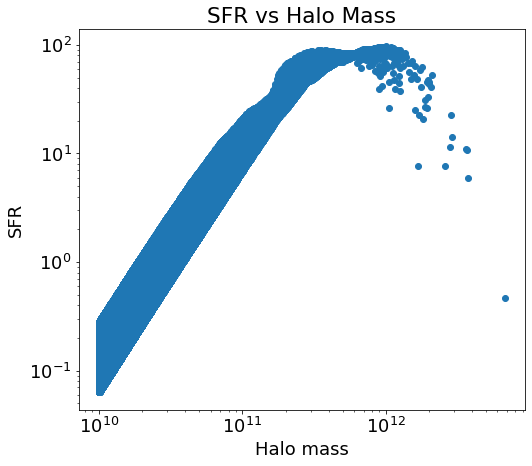

In [74]:
plt.scatter(halo_ms, halo_sfr)
plt.xscale('log')
plt.yscale('log')
plt.title('SFR vs Halo Mass')
plt.xlabel('Halo mass')
plt.ylabel('SFR')

Loading Metallicity:

In [75]:
gamma = 0.31
beta = 2.1
m_0 = 10.11
m_1 = 0.56
Z_0 = 8.779

def M_0(sfr):
    return (10**(m_0))*(sfr**(m_1))

halo_M0 = M_0(halo_sfr)

def metal(stellar_m, M_0):
    return Z_0 - (gamma/beta)*np.log10(1 + (stellar_m/M_0)**(-beta))

halo_z = metal(halo_sm, halo_M0)

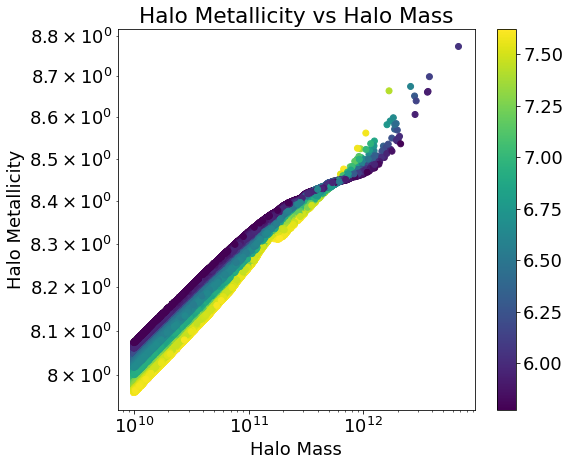

In [76]:
plt.scatter(halo_ms, halo_z, c = halo_zs)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo Metallicity vs Halo Mass')
plt.xlabel('Halo Mass')
plt.ylabel('Halo Metallicity')
plt.colorbar()

In [77]:
halos_cii = m_cii_v1.L_halos.value

/cita/modules/python/3.10.2/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


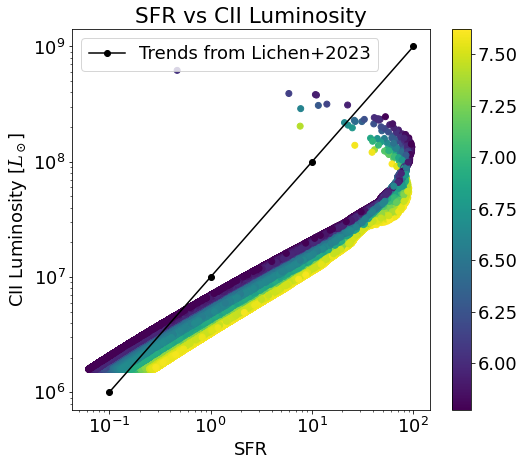

In [78]:
plt.scatter(halo_sfr, halos_cii, c = halo_zs)
plt.colorbar()
plt.title('SFR vs CII Luminosity')
plt.xlabel('SFR')
plt.ylabel(r'CII Luminosity [$L_\odot$]')
plt.xscale('log')
plt.yscale('log')
plt.plot([10**(-1), 10**(0), 10**(1), 10**(2)], [10**(6), 10**(7), 10**(8), 10**(9)], '-ok', label = 'Trends from Lichen+2023')
plt.legend()

In [61]:
m_cii_v1.catalogue_file

'/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13819.npz'

Super quick pipeline:

In [4]:
# Initialize LineModel with default model
m = lim()
m_cii = lim('Lichen_v3', doSim = True)
m_cii_v1 = lim('Lichen', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation
Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [6]:
m_cii.update(model_par = {'zdex': 0.00,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.017,
 'BehrooziFile': 'sfr_reinterp.dat'})

In [7]:
m_cii.model_par

{'zdex': 0.0,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.017,
 'BehrooziFile': 'sfr_reinterp.dat'}

In [8]:
a = lambda z:1/(1.+z)
# Behroozi et al 2013a parameters
nu = lambda z:np.exp(-4*a(z)**2)
log10_eps = lambda z:-1.777-0.006*(a(z)-1)*nu(z)-0.119*(a(z)-1)
log10_M1 = lambda z:11.514+(-1.793*(a(z)-1)-0.251*z)*nu(z)
alpha = lambda z:-1.412+0.731*(a(z)-1)*nu(z)
delta = lambda z:3.508+(2.608*(a(z)-1)-0.043*z)*nu(z)
gamma_f = lambda z:0.316+(1.319*(a(z)-1)+0.279*z)*nu(z)
f = lambda x, z:-np.log10(10**(alpha(z)*x)+1)+delta(z)*(np.log10(1+np.exp(x)))**gamma_f(z)/(1+np.exp(10**(-x)))
xi = lambda z:0.218-0.023*(a(z)-1)

def stellar_m(halo_m,z,scatter=False):
    sm = 10**(log10_eps(z)+log10_M1(z)+f(np.log10(halo_m/(10**log10_M1(z))),z)-f
(0,z))
    if scatter:
        rand = np.random.lognormal(-0.5*(xi(z)*np.log(10))**2,xi(z)*np.log(10))
        return sm*rand
    else:
        return sm

    
from limlam_mocker import limlam_mocker as llm
import scipy as sp
import scipy.interpolate
sigma_sfr = 0.3

tablepath = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/sfr_reinterp.dat'

dat_zp1, dat_logm, dat_logsfr, _ = np.loadtxt(tablepath, unpack=True)
dat_logzp1 = np.log10(dat_zp1)
dat_sfr    = 10.**dat_logsfr
dat_logzp1  = np.unique(dat_logzp1)    # log(z), 1D 
dat_logm    = np.unique(dat_logm)      # log(Mhalo), 1D        
dat_sfr     = np.reshape(dat_sfr, (dat_logm.size, dat_logzp1.size))
sfr_interp_tab = sp.interpolate.RectBivariateSpline(dat_logm, dat_logzp1, dat_sfr, kx=1, ky=1)

gamma = 0.31
beta = 2.1
m_0 = 10.11
m_1 = 0.56
Z_0 = 8.779

def M_0(sfr):
    return (10**(m_0))*(sfr**(m_1))

def metal(stellar_m, M_0):
    return Z_0 - (gamma/beta)*np.log10(1 + (stellar_m/M_0)**(-beta))

Lichen v1, no scatter in stellar mass, using median redshift:

In [9]:
halo_ms = m_cii_v1.halos.M
halo_zs = m_cii_v1.halos.redshift

map_zs = (m_cii_v1.mapinst.nu_rest/m_cii_v1.mapinst.nu_bincents) - 1
med_z = np.median(map_zs)

halo_sm = stellar_m(halo_ms, med_z)

halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs + 1))

halo_M0 = M_0(halo_sfr)

halo_z = metal(halo_sm, halo_M0)
halos_cii = m_cii_v1.L_halos.value

Loading .npz catalogues...


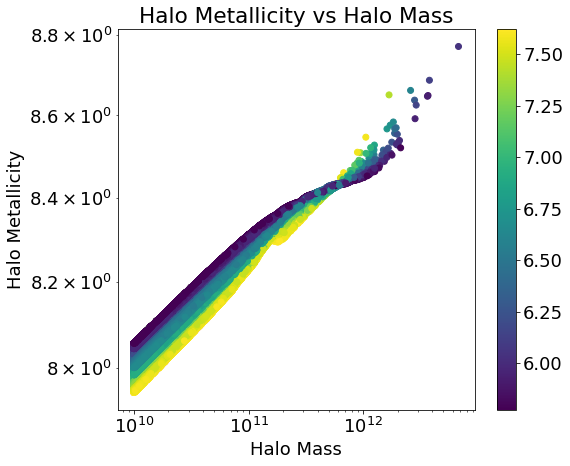

In [10]:
plt.scatter(halo_ms, halo_z, c = halo_zs)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo Metallicity vs Halo Mass')
plt.xlabel('Halo Mass')
plt.ylabel('Halo Metallicity')
plt.colorbar()

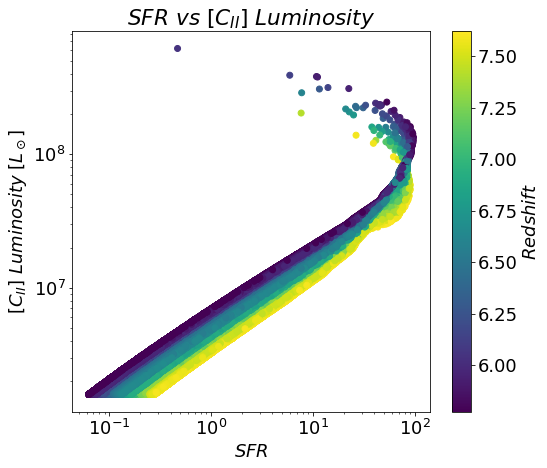

In [11]:
plt.scatter(halo_sfr, halos_cii, c = halo_zs)
plt.title(r'$SFR\ vs\ [C_{II}]\ Luminosity$')
plt.xlabel(r'$SFR$')
plt.ylabel(r'$[C_{II}]\ Luminosity\ [L_\odot]$')
plt.xscale('log')
plt.yscale('log')
#plt.plot([10**(-1), 10**(0), 10**(1), 10**(2)], [10**(6), 10**(7), 10**(8), 10**(9)], '-ok', label = 'Trends from Liang+2023')
#plt.legend()
plt.colorbar(label = r'$Redshift$')

Lichen v1, no scatter in stellar mass, using each halo redshift

In [12]:
halo_ms = m_cii_v1.halos.M
halo_zs = m_cii_v1.halos.redshift

map_zs = (m_cii_v1.mapinst.nu_rest/m_cii_v1.mapinst.nu_bincents) - 1
med_z = np.median(map_zs)

halo_sm = stellar_m(halo_ms, halo_zs)

halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs + 1))

halo_M0 = M_0(halo_sfr)

halo_z = metal(halo_sm, halo_M0)
halos_cii = m_cii_v1.L_halos.value

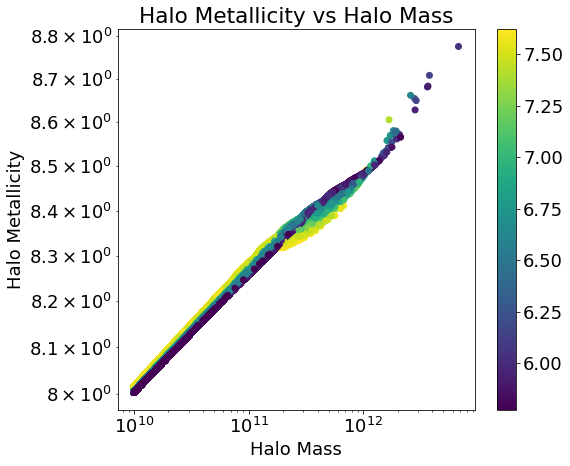

In [13]:
plt.scatter(halo_ms, halo_z, c = halo_zs)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo Metallicity vs Halo Mass')
plt.xlabel('Halo Mass')
plt.ylabel('Halo Metallicity')
plt.colorbar()

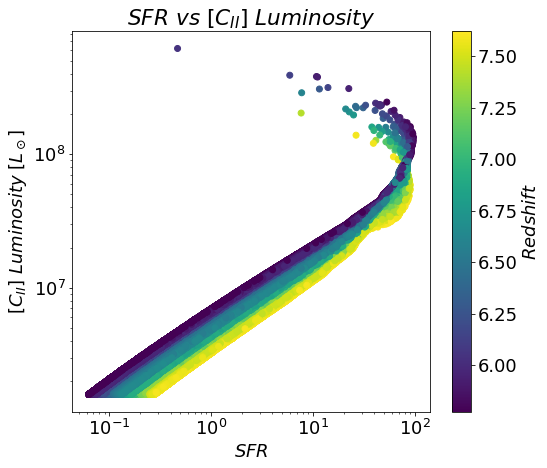

In [14]:
plt.scatter(halo_sfr, halos_cii, c = halo_zs)
plt.title(r'$SFR\ vs\ [C_{II}]\ Luminosity$')
plt.xlabel(r'$SFR$')
plt.ylabel(r'$[C_{II}]\ Luminosity\ [L_\odot]$')
plt.xscale('log')
plt.yscale('log')
#plt.plot([10**(-1), 10**(0), 10**(1), 10**(2)], [10**(6), 10**(7), 10**(8), 10**(9)], '-ok', label = 'Trends from Liang+2023')
#plt.legend()
plt.colorbar(label = r'$Redshift$')

Lichen v1, with scatter in stellar mass, using each halo redshift

In [25]:
halo_ms = m_cii_v1.halos.M
halo_zs = m_cii_v1.halos.redshift

map_zs = (m_cii_v1.mapinst.nu_rest/m_cii_v1.mapinst.nu_bincents) - 1
med_z = np.median(map_zs)

halo_sm = stellar_m(halo_ms, halo_zs)

halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs + 1))

halo_M0 = M_0(halo_sfr)

halo_z = metal(halo_sm, halo_M0)
halos_cii = m_cii_v1.L_halos.value

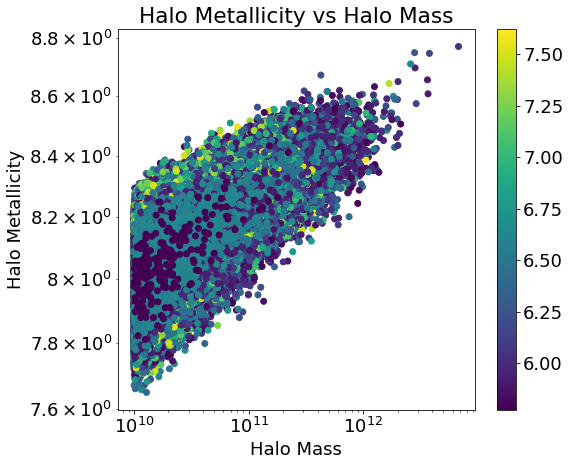

In [26]:
plt.scatter(halo_ms, halo_z, c = halo_zs)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo Metallicity vs Halo Mass')
plt.xlabel('Halo Mass')
plt.ylabel('Halo Metallicity')
plt.colorbar()

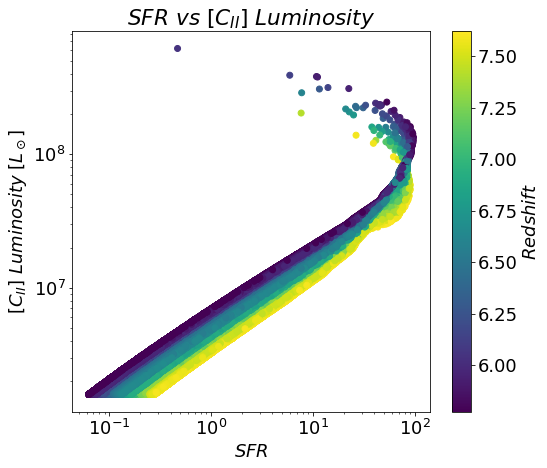

In [27]:
plt.scatter(halo_sfr, halos_cii, c = halo_zs)
plt.title(r'$SFR\ vs\ [C_{II}]\ Luminosity$')
plt.xlabel(r'$SFR$')
plt.ylabel(r'$[C_{II}]\ Luminosity\ [L_\odot]$')
plt.xscale('log')
plt.yscale('log')
#plt.plot([10**(-1), 10**(0), 10**(1), 10**(2)], [10**(6), 10**(7), 10**(8), 10**(9)], '-ok', label = 'Trends from Liang+2023')
#plt.legend()
plt.colorbar(label = r'$Redshift$')

Lichen v1, with scatter in stellar mass, using halos' median redshift

In [42]:
halo_ms = m_cii_v1.halos.M
halo_zs = m_cii_v1.halos.redshift

map_zs = (m_cii_v1.mapinst.nu_rest/m_cii_v1.mapinst.nu_bincents) - 1
med_z = np.median(map_zs)

halo_sm = stellar_m(halo_ms, med_z)

halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs + 1))

halo_M0 = M_0(halo_sfr)

halo_z = metal(halo_sm, halo_M0)
halos_cii = m_cii_v1.L_halos.value

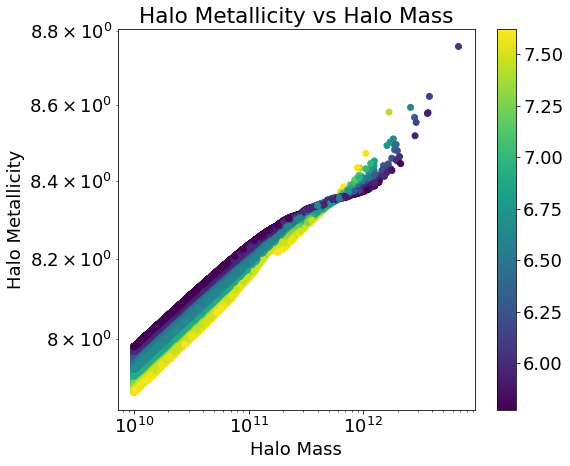

In [43]:
plt.scatter(halo_ms, halo_z, c = halo_zs)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo Metallicity vs Halo Mass')
plt.xlabel('Halo Mass')
plt.ylabel('Halo Metallicity')
plt.colorbar()

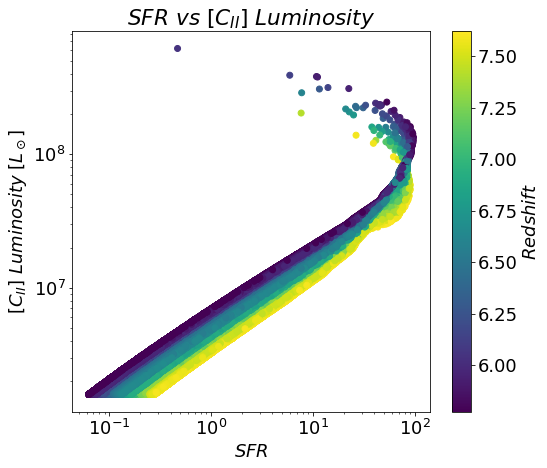

In [44]:
plt.scatter(halo_sfr, halos_cii, c = halo_zs)
plt.title(r'$SFR\ vs\ [C_{II}]\ Luminosity$')
plt.xlabel(r'$SFR$')
plt.ylabel(r'$[C_{II}]\ Luminosity\ [L_\odot]$')
plt.xscale('log')
plt.yscale('log')
#plt.plot([10**(-1), 10**(0), 10**(1), 10**(2)], [10**(6), 10**(7), 10**(8), 10**(9)], '-ok', label = 'Trends from Liang+2023')
#plt.legend()
plt.colorbar(label = r'$Redshift$')

Lichen v3, no scatter in stellar mass, no scatter in metallicity, using each halo redshift

Except there is stellar mass scatter embedded in Lichen v3!

In [64]:
m_cii.update(model_par = {'zdex': 0.3,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.017,
 'BehrooziFile': 'sfr_reinterp.dat'})

In [9]:
halo_ms = m_cii.halos.M
halo_zs = m_cii.halos.redshift

map_zs = (m_cii.mapinst.nu_rest/m_cii.mapinst.nu_bincents) - 1
med_z = np.median(map_zs)

halo_sm = stellar_m(halo_ms, halo_zs)

halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs + 1))

halo_M0 = M_0(halo_sfr)

halo_z = metal(halo_sm, halo_M0)
halos_cii = m_cii.L_halos.value

halo_IR = halo_sfr*(1.36*(10**10))

Loading .npz catalogues...


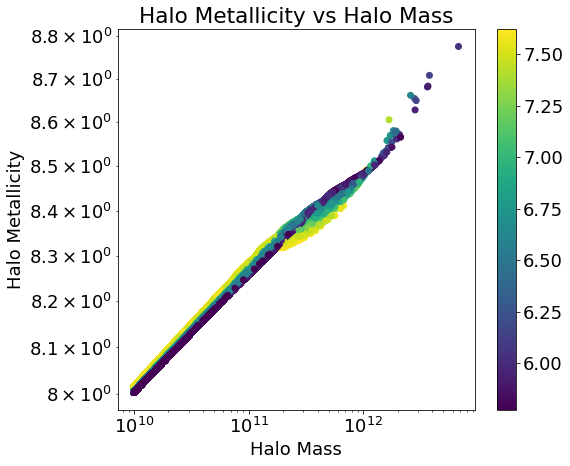

In [57]:
plt.scatter(halo_ms, halo_z, c = halo_zs)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo Metallicity vs Halo Mass')
plt.xlabel('Halo Mass')
plt.ylabel('Halo Metallicity')
plt.colorbar()

no stellar mass scatter, metallicity scatter:

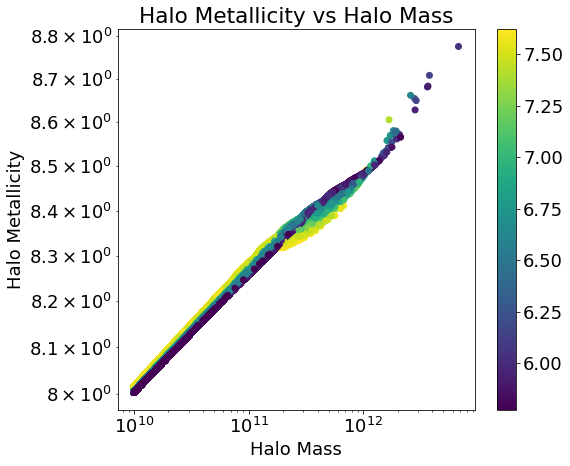

In [11]:
plt.scatter(halo_ms, halo_z, c = halo_zs)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo Metallicity vs Halo Mass')
plt.xlabel('Halo Mass')
plt.ylabel('Halo Metallicity')
plt.colorbar()

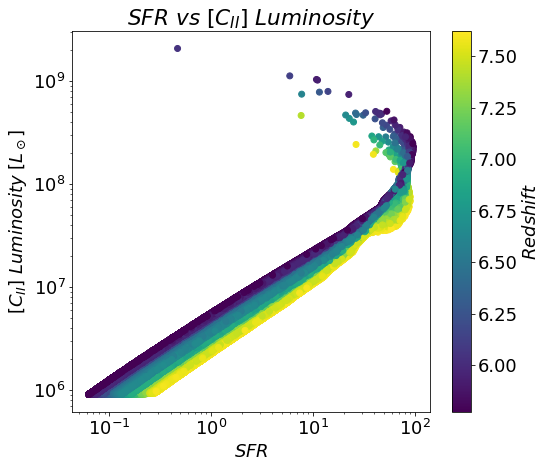

In [12]:
plt.scatter(halo_sfr, halos_cii, c = halo_zs)
plt.title(r'$SFR\ vs\ [C_{II}]\ Luminosity$')
plt.xlabel(r'$SFR$')
plt.ylabel(r'$[C_{II}]\ Luminosity\ [L_\odot]$')
plt.xscale('log')
plt.yscale('log')
#plt.plot([10**(-1), 10**(0), 10**(1), 10**(2)], [10**(6), 10**(7), 10**(8), 10**(9)], '-ok', label = 'Trends from Liang+2023')
#plt.legend()
plt.colorbar(label = r'$Redshift$')

zdex = 0.0:

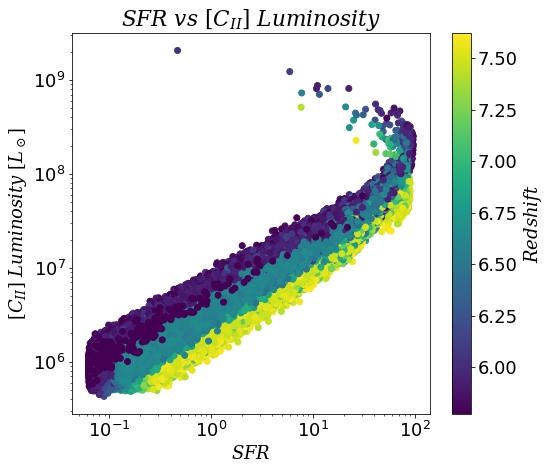

In [54]:
plt.scatter(halo_sfr, halos_cii, c = halo_zs)
plt.title(r'$SFR\ vs\ [C_{II}]\ Luminosity$')
plt.xlabel(r'$SFR$')
plt.ylabel(r'$[C_{II}]\ Luminosity\ [L_\odot]$')
plt.xscale('log')
plt.yscale('log')
#plt.plot([10**(-1), 10**(0), 10**(1), 10**(2)], [10**(6), 10**(7), 10**(8), 10**(9)], '-ok', label = 'Trends from Liang+2023')
#plt.legend()
plt.colorbar(label = r'$Redshift$')

zdex = 0.3:

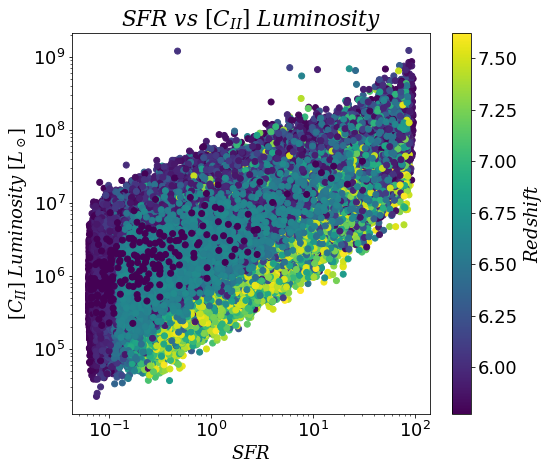

In [66]:
plt.scatter(halo_sfr, halos_cii, c = halo_zs)
plt.title(r'$SFR\ vs\ [C_{II}]\ Luminosity$')
plt.xlabel(r'$SFR$')
plt.ylabel(r'$[C_{II}]\ Luminosity\ [L_\odot]$')
plt.xscale('log')
plt.yscale('log')
#plt.plot([10**(-1), 10**(0), 10**(1), 10**(2)], [10**(6), 10**(7), 10**(8), 10**(9)], '-ok', label = 'Trends from Liang+2023')
#plt.legend()
plt.colorbar(label = r'$Redshift$')

zdex = 0.5:

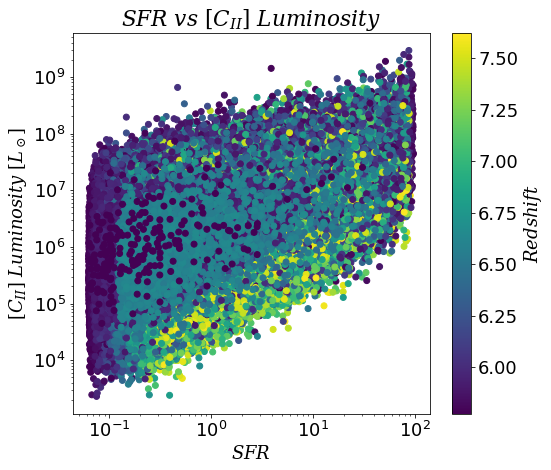

In [61]:
plt.scatter(halo_sfr, halos_cii, c = halo_zs)
plt.title(r'$SFR\ vs\ [C_{II}]\ Luminosity$')
plt.xlabel(r'$SFR$')
plt.ylabel(r'$[C_{II}]\ Luminosity\ [L_\odot]$')
plt.xscale('log')
plt.yscale('log')
#plt.plot([10**(-1), 10**(0), 10**(1), 10**(2)], [10**(6), 10**(7), 10**(8), 10**(9)], '-ok', label = 'Trends from Liang+2023')
#plt.legend()
plt.colorbar(label = r'$Redshift$')

Here, the halos' $[C_{II}]$ luminosities are scattered compared to Lichen v1 with no scatter. How?

That's because the luminosities computed with Lichen v3 have embedded stellar mass scatter

In [18]:
fire_galaxies_z6 = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies_z6.dat'
massive_z6, log_cii_z6, log_ir_z6 = np.loadtxt(fire_galaxies_z6, unpack=True)

mass_fire_z6 = massive_z6 < 0
fire_box_z6 = massive_z6 >= 0
fire_zs_z6 = [6 for i in range(len(massive_z6))]

fire_cii_z6 = 10**(log_cii_z6)
fire_ir_z6 = 10**(log_ir_z6)


fire_galaxies_z8 = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies_z8.dat'
massive_z8, log_cii_z8, log_ir_z8 = np.loadtxt(fire_galaxies_z8, unpack=True)

mass_fire_z8 = massive_z8 < 0
fire_box_z8 = massive_z8 >= 0
fire_zs_z8 = [8 for i in range(len(massive_z8))]

fire_cii_z8 = 10**(log_cii_z8)
fire_ir_z8 = 10**(log_ir_z8)

In [23]:
import random
0.001*len(halo_IR) #1862
rand_halos = random.sample([i for i in range(len(halo_IR))], 1862)
rand_halos = np.array(rand_halos)

No stellar mass scatter, no metallicity scatter:

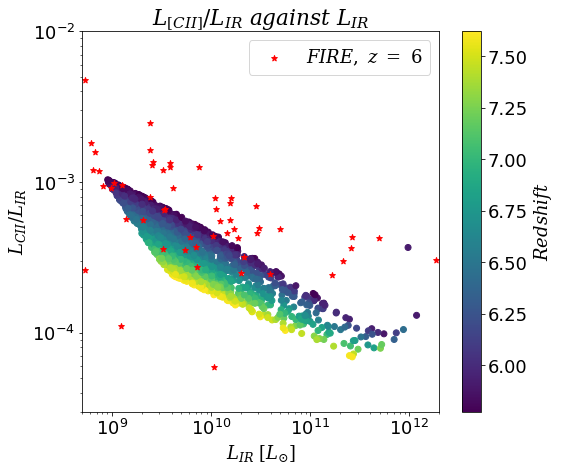

In [15]:
plt.rcParams["mathtext.fontset"] = "dejavuserif"

plt.scatter(halo_IR[rand_halos], (halos_cii/halo_IR)[rand_halos], c = halo_zs[rand_halos])
plt.colorbar(label = r'$Redshift$')
plt.title(r'$L_{[CII]}/L_{IR}\ against\ L_{IR}$')
plt.scatter(fire_ir, (fire_cii/fire_ir), c = 'r', marker = '*', label = r'$FIRE,\ z\ =\ 6$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ [L_{\odot}]$')
plt.ylabel(r'$L_{CII}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()

zdex = 0.0:

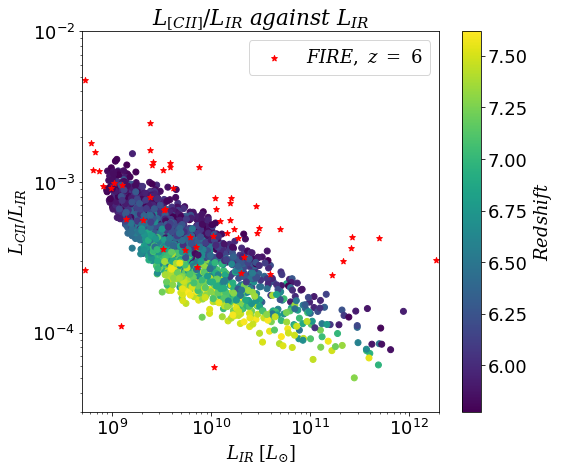

In [58]:
plt.rcParams["mathtext.fontset"] = "dejavuserif"

plt.scatter(halo_IR[rand_halos], (halos_cii/halo_IR)[rand_halos], c = halo_zs[rand_halos])
plt.colorbar(label = r'$Redshift$')
plt.title(r'$L_{[CII]}/L_{IR}\ against\ L_{IR}$')
plt.scatter(fire_ir, (fire_cii/fire_ir), c = 'r', marker = '*', label = r'$FIRE,\ z\ =\ 6$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ [L_{\odot}]$')
plt.ylabel(r'$L_{CII}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()

zdex = 0.3:

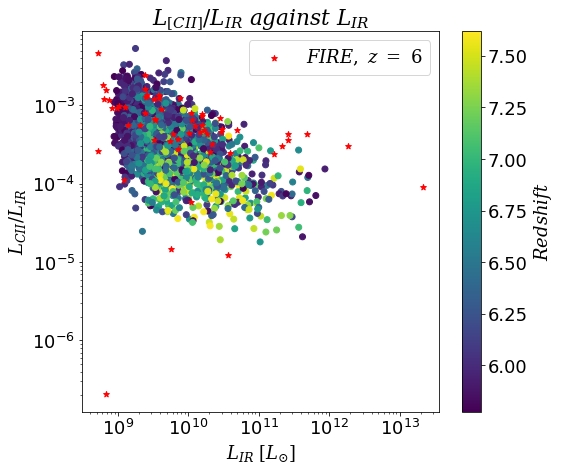

In [67]:
plt.rcParams["mathtext.fontset"] = "dejavuserif"

plt.scatter(halo_IR[rand_halos], (halos_cii/halo_IR)[rand_halos], c = halo_zs[rand_halos])
plt.colorbar(label = r'$Redshift$')
plt.title(r'$L_{[CII]}/L_{IR}\ against\ L_{IR}$')
plt.scatter(fire_ir, (fire_cii/fire_ir), c = 'r', marker = '*', label = r'$FIRE,\ z\ =\ 6$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ [L_{\odot}]$')
plt.ylabel(r'$L_{CII}/L_{IR}$')
#plt.xlim([5*(10**8), 2*(10**12)])
#plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()

zdex = 0.5:

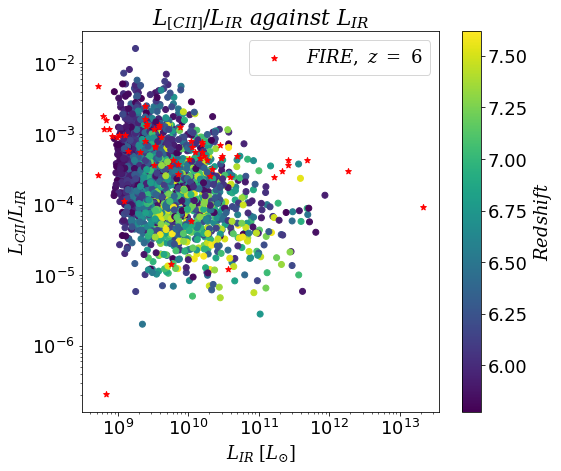

In [63]:
plt.rcParams["mathtext.fontset"] = "dejavuserif"

plt.scatter(halo_IR[rand_halos], (halos_cii/halo_IR)[rand_halos], c = halo_zs[rand_halos])
plt.colorbar(label = r'$Redshift$')
plt.title(r'$L_{[CII]}/L_{IR}\ against\ L_{IR}$')
plt.scatter(fire_ir, (fire_cii/fire_ir), c = 'r', marker = '*', label = r'$FIRE,\ z\ =\ 6$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ [L_{\odot}]$')
plt.ylabel(r'$L_{CII}/L_{IR}$')
#plt.xlim([5*(10**8), 2*(10**12)])
#plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()

Checking the behavior of log normal scatter on log scale:

In [85]:
import limlam_mocker.limlam_mocker as llm
from astropy.modeling.models import Lorentz1D

In [103]:
x = np.linspace(0, 2, 100)
y = np.exp(x)
y_scatter = llm.add_log_normal_scatter(y, 0.3, seed = 23)

x1 = np.linspace(-2, 2, 100)
s1 = Lorentz1D()
y1 = s1(x1)
y1_scatter = llm.add_log_normal_scatter(y1, 0.3, seed = 23)

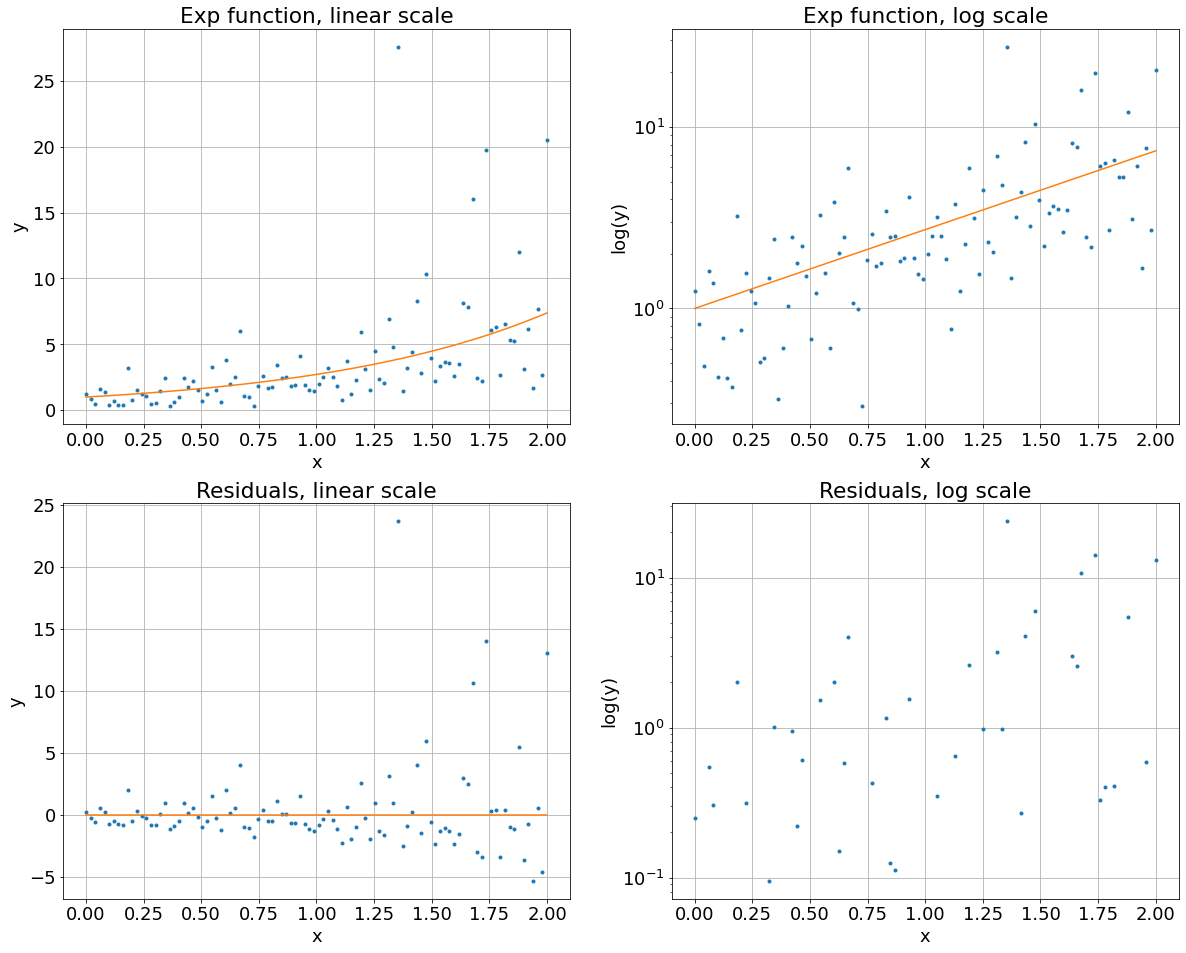

In [102]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 16))

plt.subplot(221)
plt.plot(x, y_scatter, '.')
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exp function, linear scale')
plt.grid()

plt.subplot(222)
plt.plot(x, y_scatter, '.')
plt.plot(x, y)
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('log(y)')
plt.title('Exp function, log scale')
plt.grid()

plt.subplot(223)
plt.plot(x, y_scatter - y, '.')
plt.plot(x, y - y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Residuals, linear scale')
plt.grid()

plt.subplot(224)
plt.plot(x, y_scatter - y, '.')
plt.plot(x, y - y)
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('log(y)')
plt.title('Residuals, log scale')
plt.grid()

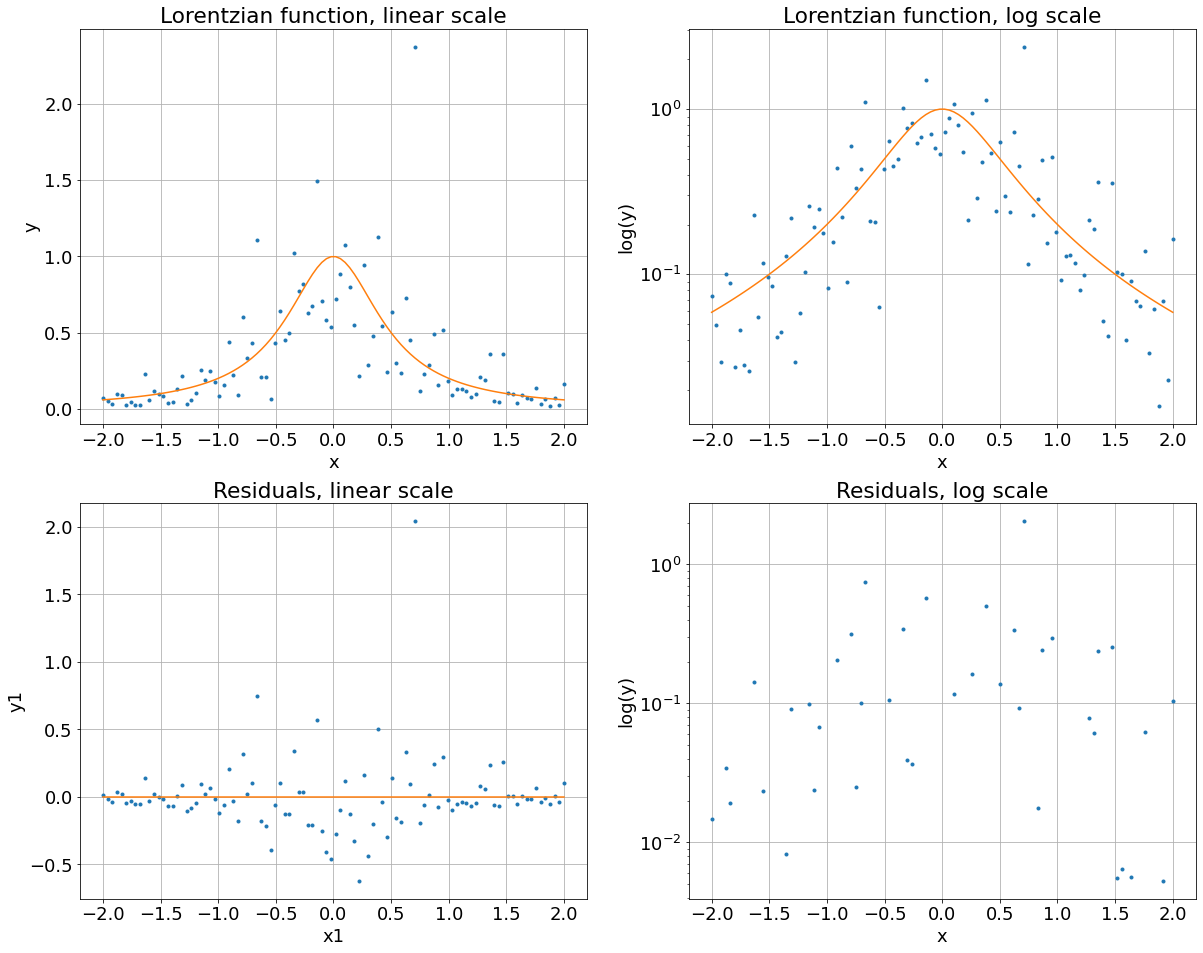

In [104]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 16))

plt.subplot(221)
plt.plot(x1, y1_scatter, '.')
plt.plot(x1, y1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lorentzian function, linear scale')
plt.grid()

plt.subplot(222)
plt.plot(x1, y1_scatter, '.')
plt.plot(x1, y1)
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('log(y)')
plt.title('Lorentzian function, log scale')
plt.grid()

plt.subplot(223)
plt.plot(x1, y1_scatter - y1, '.')
plt.plot(x1, y1 - y1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Residuals, linear scale')
plt.grid()

plt.subplot(224)
plt.plot(x1, y1_scatter - y1, '.')
plt.plot(x1, y1 - y1)
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('log(y)')
plt.title('Residuals, log scale')
plt.grid()

Alright... well I thought that the data being skewed down on log-scale axis (c.f. L_CII/L_IR plots) could be due to a symmetrical spread in linear-scale, which would naturally result in this effect. But it's not as clear given the results here.

Now try with Lichen v3 but no scatter in stellar mass:

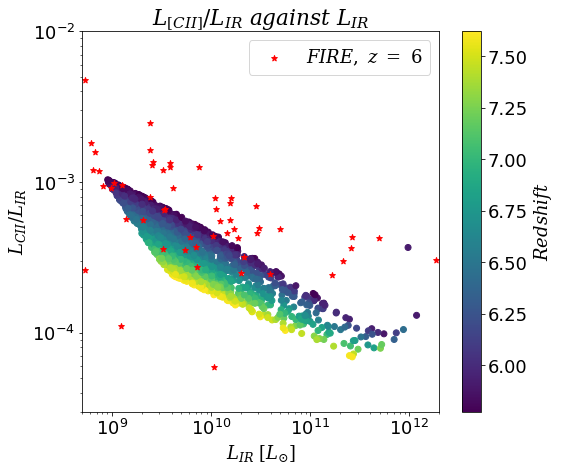

In [16]:
plt.rcParams["mathtext.fontset"] = "dejavuserif"

plt.scatter(halo_IR[rand_halos], (halos_cii/halo_IR)[rand_halos], c = halo_zs[rand_halos])
plt.colorbar(label = r'$Redshift$')
plt.title(r'$L_{[CII]}/L_{IR}\ against\ L_{IR}$')
plt.scatter(fire_ir, (fire_cii/fire_ir), c = 'r', marker = '*', label = r'$FIRE,\ z\ =\ 6$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ [L_{\odot}]$')
plt.ylabel(r'$L_{CII}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()

Indeed, the trend is skewed down! It's not an effect of the scatter. So that is due to the new formula, with the metallicity included to the relationship.

## June 6th - Adding $z$ = 8 FIRE galaxies

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]
from scipy.ndimage import gaussian_filter
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [6]:
# Initialize LineModel with default model
m = lim()
m_cii = lim('Lichen_v3', doSim = True)
m_cii_v1 = lim('Lichen', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation
Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [267]:
m_cii.update(model_par = {'zdex': 0.0,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.017,
 'BehrooziFile': 'sfr_reinterp.dat'},
            nuObs = 270*u.GHz,
            Delta_nu = 40*u.GHz,
             dnu = 1.11*u.GHz)

In [268]:
m_cii_v1.update(nuObs = 270*u.GHz,
            Delta_nu = 40*u.GHz,
               dnu = 1.11*u.GHz)

In [269]:
a = lambda z:1/(1.+z)
# Behroozi et al 2013a parameters
nu = lambda z:np.exp(-4*a(z)**2)
log10_eps = lambda z:-1.777-0.006*(a(z)-1)*nu(z)-0.119*(a(z)-1)
log10_M1 = lambda z:11.514+(-1.793*(a(z)-1)-0.251*z)*nu(z)
alpha = lambda z:-1.412+0.731*(a(z)-1)*nu(z)
delta = lambda z:3.508+(2.608*(a(z)-1)-0.043*z)*nu(z)
gamma_f = lambda z:0.316+(1.319*(a(z)-1)+0.279*z)*nu(z)
f = lambda x, z:-np.log10(10**(alpha(z)*x)+1)+delta(z)*(np.log10(1+np.exp(x)))**gamma_f(z)/(1+np.exp(10**(-x)))
xi = lambda z:0.218-0.023*(a(z)-1)

def stellar_m(halo_m,z,scatter=False):
    sm = 10**(log10_eps(z)+log10_M1(z)+f(np.log10(halo_m/(10**log10_M1(z))),z)-f
(0,z))
    if scatter:
        rand = np.random.lognormal(-0.5*(xi(z)*np.log(10))**2,xi(z)*np.log(10))
        return sm*rand
    else:
        return sm

    
from limlam_mocker import limlam_mocker as llm
import scipy as sp
import scipy.interpolate
sigma_sfr = 0.3

tablepath = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/sfr_reinterp.dat'

dat_zp1, dat_logm, dat_logsfr, _ = np.loadtxt(tablepath, unpack=True)
dat_logzp1 = np.log10(dat_zp1)
dat_sfr    = 10.**dat_logsfr
dat_logzp1  = np.unique(dat_logzp1)    # log(z), 1D 
dat_logm    = np.unique(dat_logm)      # log(Mhalo), 1D        
dat_sfr     = np.reshape(dat_sfr, (dat_logm.size, dat_logzp1.size))
sfr_interp_tab = sp.interpolate.RectBivariateSpline(dat_logm, dat_logzp1, dat_sfr, kx=1, ky=1)

gamma = 0.31
beta = 2.1
m_0 = 10.11
m_1 = 0.56
Z_0 = 8.779

def M_0(sfr):
    return (10**(m_0))*(sfr**(m_1))

def metal(stellar_m, M_0):
    return Z_0 - (gamma/beta)*np.log10(1 + (stellar_m/M_0)**(-beta))

In [270]:
halo_ms = m_cii_v1.halos.M
halo_zs = m_cii_v1.halos.redshift

map_zs = (m_cii_v1.mapinst.nu_rest/m_cii_v1.mapinst.nu_bincents) - 1
med_z = np.median(map_zs)

halo_sm = stellar_m(halo_ms, med_z)

halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs + 1))
halo_IR = halo_sfr*(1.36*(10**10))

halo_M0 = M_0(halo_sfr)

halo_z = metal(halo_sm, halo_M0)

halos_cii_v1 = m_cii_v1.L_halos.value
halos_cii_v2 = m_cii.L_halos.value

Loading .npz catalogues...
Loading .npz catalogues...


In [35]:
fire_galaxies_z6 = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies_z6.dat'
massive_z6, log_cii_z6, log_ir_z6 = np.loadtxt(fire_galaxies_z6, unpack=True)

mass_fire_z6 = massive_z6 < 0
fire_box_z6 = massive_z6 >= 0
fire_zs_z6 = [6 for i in range(len(massive_z6))]

fire_cii_z6 = 10**(log_cii_z6)
fire_ir_z6 = 10**(log_ir_z6)


fire_galaxies_z8 = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies_z8.dat'
massive_z8, log_cii_z8, log_ir_z8 = np.loadtxt(fire_galaxies_z8, unpack=True)

mass_fire_z8 = massive_z8 < 0
fire_box_z8 = massive_z8 >= 0
fire_zs_z8 = [8 for i in range(len(massive_z8))]

fire_cii_z8 = 10**(log_cii_z8)
fire_ir_z8 = 10**(log_ir_z8)

In [36]:
import random
0.001*len(halo_IR) #1862
rand_halos = random.sample([i for i in range(len(halo_IR))], 1862)
rand_halos = np.array(rand_halos)

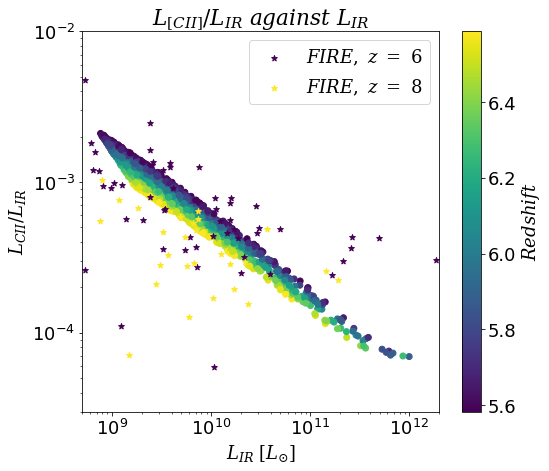

In [230]:
plt.scatter(halo_IR[rand_halos], (halos_cii_v1/halo_IR)[rand_halos], c = halo_zs[rand_halos])
plt.colorbar(label = r'$Redshift$')
plt.title(r'$L_{[CII]}/L_{IR}\ against\ L_{IR}$')
plt.scatter(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', label = r'$FIRE,\ z\ =\ 6$')
plt.scatter(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', label = r'$FIRE,\ z\ =\ 8$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ [L_{\odot}]$')
plt.ylabel(r'$L_{CII}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()

#plt.savefig('paper_figs/fig6/fig6_v1_nu212-240GHz.png')

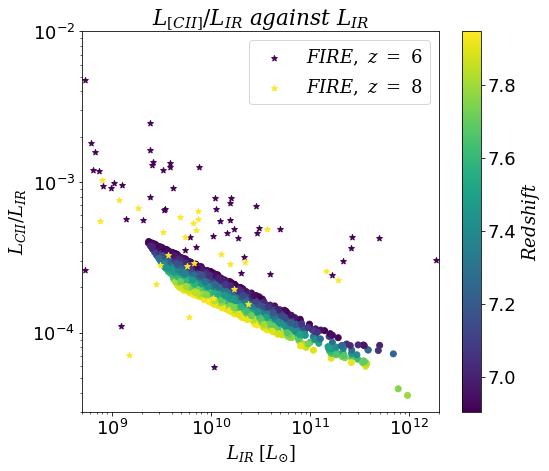

In [38]:
plt.scatter(halo_IR[rand_halos], (halos_cii_v2/halo_IR)[rand_halos], c = halo_zs[rand_halos])
plt.colorbar(label = r'$Redshift$')
plt.title(r'$L_{[CII]}/L_{IR}\ against\ L_{IR}$')
plt.scatter(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', label = r'$FIRE,\ z\ =\ 6$')
plt.scatter(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', label = r'$FIRE,\ z\ =\ 8$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ [L_{\odot}]$')
plt.ylabel(r'$L_{CII}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])
plt.legend()

#plt.savefig('paper_figs/fig6/fig6_v2_nu212-240GHz.png')

In [42]:
(halos_cii_v2/halo_IR)[0]

5.8284637561582745e-05

In [45]:
tt = halo_IR == halo_IR[0]

In [47]:
halo_IR[tt]

array([4.86259745e+11])

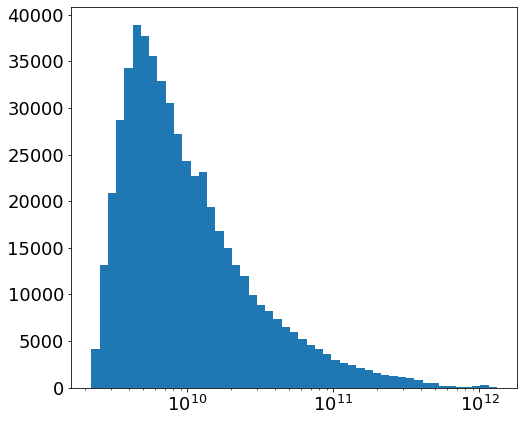

In [220]:
_, ir_bins, _ = plt.hist(halo_IR, bins = np.logspace(np.min(np.log10(halo_IR)), np.max(np.log10(halo_IR)), 50))
plt.xscale('log')

In [221]:
len(ir_bins)

50

In [222]:
ir_center = (ir_bins[:-1] + ir_bins[1:]) / 2

v1, z = 8:

In [223]:
v1z8 = halo_zs > 7

In [224]:
len(halo_zs[v1z8])

464230

In [225]:
ind_v1z8 = [0 for i in range(len(ir_bins) - 1)]
med_v1z8 = [0 for i in range(len(ir_bins) - 1)]

perc68_down_v1z8 = [0 for i in range(len(ir_bins) - 1)]
perc68_up_v1z8 = [0 for i in range(len(ir_bins) - 1)]

perc95_down_v1z8 = [0 for i in range(len(ir_bins) - 1)]
perc95_up_v1z8 = [0 for i in range(len(ir_bins) - 1)]

perc997_down_v1z8 = [0 for i in range(len(ir_bins) - 1)]
perc997_up_v1z8 = [0 for i in range(len(ir_bins) - 1)]


for i in range(len(ir_bins) - 1):
    
    ind_v1z8[i] = (halo_IR[v1z8] >= ir_bins[i]) & (halo_IR[v1z8] <= ir_bins[i+1])
    med_v1z8[i] = np.median((halos_cii_v1/halo_IR)[v1z8][ind_v1z8[i]])
    
    perc68_down_v1z8[i] = np.percentile((halos_cii_v1/halo_IR)[v1z8][ind_v1z8[i]], 0.15+2.35+13.5)
    perc68_up_v1z8[i] = np.percentile((halos_cii_v1/halo_IR)[v1z8][ind_v1z8[i]], 0.15+2.35+13.5+68)
    
    perc95_down_v1z8[i] = np.percentile((halos_cii_v1/halo_IR)[v1z8][ind_v1z8[i]], 0.15+2.35)
    perc95_up_v1z8[i] = np.percentile((halos_cii_v1/halo_IR)[v1z8][ind_v1z8[i]], 0.15+2.35+13.5+68+13.5)
    
    perc997_down_v1z8[i] = np.percentile((halos_cii_v1/halo_IR)[v1z8][ind_v1z8[i]], 0.15)
    perc997_up_v1z8[i] = np.percentile((halos_cii_v1/halo_IR)[v1z8][ind_v1z8[i]], 0.15+2.35+13.5+68+13.5+2.35)

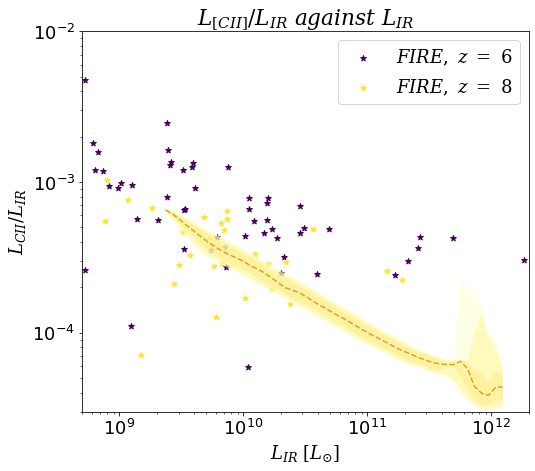

In [226]:
f, a = plt.subplots()

plt.title(r'$L_{[CII]}/L_{IR}\ against\ L_{IR}$')
a.scatter(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', label = r'$FIRE,\ z\ =\ 6$')
a.scatter(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', label = r'$FIRE,\ z\ =\ 8$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ [L_{\odot}]$')
plt.ylabel(r'$L_{CII}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])

a.fill_between(ir_center, perc68_down_v1z8, perc68_up_v1z8, facecolor='#F4C430', alpha = 0.5)
a.fill_between(ir_center, perc95_down_v1z8, perc95_up_v1z8, facecolor='#FBEC5D', alpha = 0.5)
a.fill_between(ir_center, perc997_down_v1z8, perc997_up_v1z8, facecolor='#FFFFCC', alpha = 0.5)

p01 = a.plot(ir_center, med_v1z8, color = '#DAA520', linestyle = '--')
#p02 = a.fill(np.nan, np.nan, alpha=0.5, edgecolor='#000000', facecolor='#010101') # for legend

a.legend()

v1z6: update m_cii_v1 above with desired nuObs and Delta_nu (270GHz and 40GHz):

In [231]:
def reg_ir(ir_bin, vnzn, halos_cii):

    ind = [0 for i in range(len(ir_bin) - 1)]
    med = [0 for i in range(len(ir_bin) - 1)]

    perc68_down = [0 for i in range(len(ir_bin) - 1)]
    perc68_up = [0 for i in range(len(ir_bin) - 1)]

    perc95_down = [0 for i in range(len(ir_bin) - 1)]
    perc95_up = [0 for i in range(len(ir_bin) - 1)]

    perc997_down = [0 for i in range(len(ir_bin) - 1)]
    perc997_up = [0 for i in range(len(ir_bin) - 1)]


    for i in range(len(ir_bin) - 1):
    
        ind[i] = (halo_IR[vnzn] >= ir_bin[i]) & (halo_IR[vnzn] <= ir_bin[i+1])
        med[i] = np.median((halos_cii/halo_IR)[vnzn][ind[i]])
    
        perc68_down[i] = np.percentile((halos_cii/halo_IR)[vnzn][ind[i]], 0.15+2.35+13.5)
        perc68_up[i] = np.percentile((halos_cii/halo_IR)[vnzn][ind[i]], 0.15+2.35+13.5+68)
    
        perc95_down[i] = np.percentile((halos_cii/halo_IR)[vnzn][ind[i]], 0.15+2.35)
        perc95_up[i] = np.percentile((halos_cii/halo_IR)[vnzn][ind[i]], 0.15+2.35+13.5+68+13.5)
    
        perc997_down[i] = np.percentile((halos_cii/halo_IR)[vnzn][ind[i]], 0.15)
        perc997_up[i] = np.percentile((halos_cii/halo_IR)[vnzn][ind[i]], 0.15+2.35+13.5+68+13.5+2.35)
        
    
    return med, perc68_down, perc68_up, perc95_down, perc95_up, perc997_down, perc997_up

In [232]:
np.min(halo_zs)

5.56660388093489

In [234]:
v1z6 = (halo_zs > 5.5) & (halo_zs < 6.5)

In [235]:
med_v1z6, perc68_down_v1z6, perc68_up_v1z6, perc95_down_v1z6, perc95_up_v1z6, perc997_down_v1z6, perc997_up_v1z6 = reg_ir(ir_bins, v1z6, halos_cii_v1)

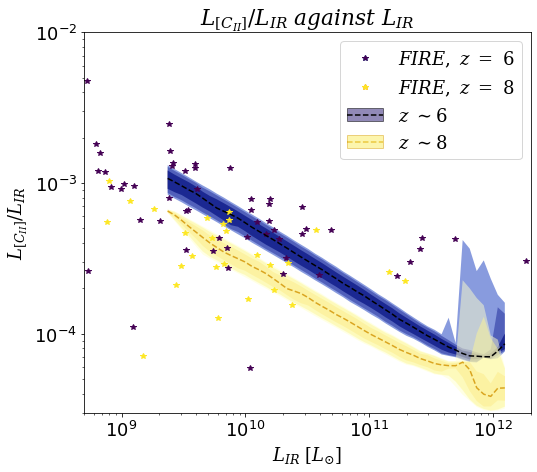

In [290]:
f, a = plt.subplots()

plt.title(r'$L_{[C_{II}]}/L_{IR}\ against\ L_{IR}$')

p6 = a.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', label = r'$FIRE,\ z\ =\ 6$', linestyle = "None")
p6l = a.plot(np.nan, np.nan, '*')

p8 = a.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', label = r'$FIRE,\ z\ =\ 8$', linestyle = "None")
p8l = a.plot(np.nan, np.nan, '*')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ [L_{\odot}]$')
plt.ylabel(r'$L_{[C_{II}]}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])

a.fill_between(ir_center, perc68_down_v1z6, perc68_up_v1z6, facecolor='#281E5D')
a.fill_between(ir_center, perc95_down_v1z6, perc95_up_v1z6, facecolor='#241571', alpha = 0.5)
a.fill_between(ir_center, perc997_down_v1z6, perc997_up_v1z6, facecolor='#1338BE', alpha = 0.5)

p01 = a.plot(ir_center, med_v1z6, color = 'k', linestyle = '--')
p02 = a.fill(np.nan, np.nan, alpha=0.5, edgecolor='k', facecolor='#241571') # for legend


a.fill_between(ir_center, perc68_down_v1z8, perc68_up_v1z8, facecolor='#F4C430', alpha = 0.5)
a.fill_between(ir_center, perc95_down_v1z8, perc95_up_v1z8, facecolor='#FBEC5D', alpha = 0.5)
a.fill_between(ir_center, perc997_down_v1z8, perc997_up_v1z8, facecolor='#FFFFCC', alpha = 0.5)

p03 = a.plot(ir_center, med_v1z8, color = '#DAA520', linestyle = '--')
p04 = a.fill(np.nan, np.nan, alpha=0.5, edgecolor='#DAA520', facecolor='#FBEC5D') # for legend


a.legend([(p6l[0], p6[0]), (p8l[0], p8[0]), (p02[0], p01[0]), (p03[0], p04[0]), ], [(r'$FIRE,\ z\ =\ 6$'), (r'$FIRE,\ z\ =\ 8$'), (r'$z\ \sim 6$'), (r'$z\ \sim 8$'), ], bbox_to_anchor = (1,1))
plt.savefig('paper_figs/fig6_lcii_lir/fig6_v1_reg.png', bbox_inches = 'tight')

v2:

In [265]:
v2z8 = halo_zs > 7

In [266]:
med_v2z8, perc68_down_v2z8, perc68_up_v2z8, perc95_down_v2z8, perc95_up_v2z8, perc997_down_v2z8, perc997_up_v2z8 = reg_ir(ir_bins, v2z8, halos_cii_v2)

In [272]:
v2z6 = (halo_zs > 5.5) & (halo_zs < 6.5)

In [273]:
med_v2z6, perc68_down_v2z6, perc68_up_v2z6, perc95_down_v2z6, perc95_up_v2z6, perc997_down_v2z6, perc997_up_v2z6 = reg_ir(ir_bins, v2z6, halos_cii_v2)

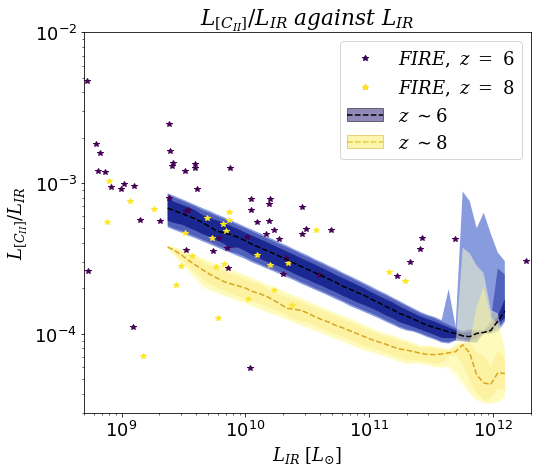

In [293]:
f, a = plt.subplots()

plt.title(r'$L_{[C_{II}]}/L_{IR}\ against\ L_{IR}$')

p6 = a.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', label = r'$FIRE,\ z\ =\ 6$', linestyle = "None")
p6l = a.plot(np.nan, np.nan, '*')

p8 = a.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', label = r'$FIRE,\ z\ =\ 8$', linestyle = "None")
p8l = a.plot(np.nan, np.nan, '*')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ [L_{\odot}]$')
plt.ylabel(r'$L_{[C_{II}]}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])
a.legend()

a.fill_between(ir_center, perc68_down_v2z6, perc68_up_v2z6, facecolor='#281E5D')
a.fill_between(ir_center, perc95_down_v2z6, perc95_up_v2z6, facecolor='#241571', alpha = 0.5)
a.fill_between(ir_center, perc997_down_v2z6, perc997_up_v2z6, facecolor='#1338BE', alpha = 0.5)

p01 = a.plot(ir_center, med_v2z6, color = 'k', linestyle = '--')
p02 = a.fill(np.nan, np.nan, alpha=0.5, edgecolor='k', facecolor='#241571') # for legend


a.fill_between(ir_center, perc68_down_v2z8, perc68_up_v2z8, facecolor='#F4C430', alpha = 0.5)
a.fill_between(ir_center, perc95_down_v2z8, perc95_up_v2z8, facecolor='#FBEC5D', alpha = 0.5)
a.fill_between(ir_center, perc997_down_v2z8, perc997_up_v2z8, facecolor='#FFFFCC', alpha = 0.5)

p03 = a.plot(ir_center, med_v2z8, color = '#DAA520', linestyle = '--')
p04 = a.fill(np.nan, np.nan, alpha=0.5, edgecolor='#DAA520', facecolor='#FBEC5D') # for legend


a.legend([(p6l[0], p6[0]), (p8l[0], p8[0]), (p02[0], p01[0]), (p03[0], p04[0]), ], [(r'$FIRE,\ z\ =\ 6$'), (r'$FIRE,\ z\ =\ 8$'), (r'$z\ \sim 6$'), (r'$z\ \sim 8$'), ], bbox_to_anchor = (1,1))
plt.savefig('paper_figs/fig6_lcii_lir/fig6_v2_reg_b.png', bbox_inches = 'tight')

In [263]:
len(halo_IR)

536322